# 0.0 Imports

In [1]:
import inflection
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics       as m
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn import cluster       as c
from sklearn import mixture       as mx
from scipy.cluster import hierarchy as hc
import umap.umap_ as umap
from sklearn         import preprocessing  as pp
from sklearn import manifold      as mn
from sklearn import ensemble      as en
from sklearn import decomposition as dd
from pandas_profiling import ProfileReport
from IPython.display import HTML
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer 
from sklearn.neighbors import NearestNeighbors
import sqlite3
from sqlalchemy import create_engine, text

/var/folders/wt/4bhdq9gj4vnbrm086fldm7z80000gn/T/ipykernel_1534/1846496563.py:16: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/luishmq/.pyenv/versions/3.8.13/envs/insiders_clustering/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading Data

In [3]:
# Carregando dados
df_raw = pd.read_csv('../data/Ecommerce.csv')

In [4]:
# Dropando coluna extra
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

In [5]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 Data Description

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
# Mudar para snake case
old_cols = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

snake_case = lambda x: inflection.underscore(x)

new_cols = list( map(snake_case, old_cols))
df1.columns = new_cols

## 1.2 Data Dimensions

In [8]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data Types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Fill NA

In [11]:
# Dropando valores NA nas colunas 'description' e 'customer_id'
df1 = df1.dropna( subset=['description', 'customer_id'] )
print( 'Removed data: {:.2f}'.format( 1-( df1.shape[0] / df_raw.shape[0] ) ) )

Removed data: 0.25


## 1.6 Change dtypes

In [12]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

df1['customer_id'] = df1['customer_id'].astype(np.int64)

### 1.6.1 Final Check

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Estatistical

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [15]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### 1.7.2 Categorical Attributes

#### 1.7.2.1 Invoice No

In [16]:
# Temos invoice com letras e numeros

# Identficacao: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 8905
Total number of negative quantity: 8905


#### 1.7.2.2 Stock Code

In [17]:
# Checagem do stock code 
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

#### 1.7.2.3 Country

In [18]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [19]:
df_countries = df1[['country', 'customer_id']].drop_duplicates().groupby('country').count().reset_index().sort_values( 'customer_id', ascending=False).head()
df_countries

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25


# 2.0 Variable Filtering

In [20]:
df2 = df1.copy()

In [21]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'] )]

# description
df2 = df2.drop( columns='description', axis=1 )

# map 
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# 3.0 Feature Engineering

In [22]:
df3 = df2.copy()

## Modelo RFM

RFM é a junção de três siglas: Recência, Frequência e Monetaridade. Essa técnica lhe permitirá entender melhor seu cliente ao verificar quando foi sua última compra, quantas vezes ele já comprou e quanto já gastou com sua empresa. Nesse sentido, tem como principal objetivo fidelizar e recompensar quem já ama a marca e reativar quem está prestes a deixar de usá-la, munindo-se de uma técnica chamada Targeting Marketing. Nessa técnica, campanhas e ações são direcionadas à pessoas que fazem parte de um mesmo segmento, visando assim uma taxa de conversão maior e, consequentemente, maior receita.

- Recency( Recência ): Tempo desde a última compra

- Frequency( Frequência ): Frequência de compra

- Monetary( Valor gasto ): Valor total de compra

In [23]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

## 3.1 Gross Revenue

In [24]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

/var/folders/wt/4bhdq9gj4vnbrm086fldm7z80000gn/T/ipykernel_1534/206990356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    27
dtype: int64

## 3.2 Recency

In [25]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

## 3.3 Quantity of purchased

In [26]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
qtde_invoices    27
dtype: int64

## 3.4 Quantity total of items purchased

In [27]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
qtde_invoices    27
qtde_items       27
dtype: int64

## 3.5 Quantity of products purchased

In [28]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
qtde_invoices    27
qtde_items       27
qtde_products    27
dtype: int64

## 3.5 Average Ticket Value

In [29]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
qtde_invoices    27
qtde_items       27
qtde_products    27
avg_ticket       27
dtype: int64

## 3.1.6 Average Recency Days

In [30]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, False] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         27
recency_days          27
qtde_invoices         27
qtde_items            27
qtde_products         27
avg_ticket            27
avg_recency_days    1386
dtype: int64

## 3.7 Frequency Purchase

In [31]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id            0
gross_revenue         27
recency_days          27
qtde_invoices         27
qtde_items            27
qtde_products         27
avg_ticket            27
avg_recency_days    1386
frequency             27
dtype: int64

## 3.8 Number of Returns

In [32]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         27
recency_days          27
qtde_invoices         27
qtde_items            27
qtde_products         27
avg_ticket            27
avg_recency_days    1386
frequency             27
qtde_returns           0
dtype: int64

## 3.9 Basket Size - Quantidade de Items por Cesta ( Quantity )

In [33]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         27
recency_days          27
qtde_invoices         27
qtde_items            27
qtde_products         27
avg_ticket            27
avg_recency_days    1386
frequency             27
qtde_returns           0
avg_basket_size       27
dtype: int64

## 3.10 Unique Basket Size - Quantidade de produtos distintos por compra

In [34]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               27
recency_days                27
qtde_invoices               27
qtde_items                  27
qtde_products               27
avg_ticket                  27
avg_recency_days          1386
frequency                   27
qtde_returns                 0
avg_basket_size             27
avg_unique_basket_size      27
dtype: int64

# 4.0 EDA

In [35]:
df4 = df3.copy()

In [36]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

In [37]:
# profile = ProfileReport(df4)
# profile.to_file('output.html')

Metricas para olharmos
1. Clusters Coesos - Separados
2. Métricas
    - Min, Máximo, Range ( Dispersão )
    - Média e Mediana
    - Desvio Padrão e Variância
    - Coeficiente de Variação ( CV )
    - Distribuição

### 4.1.1 Gross Revenue

In [38]:
df4.sort_values( 'gross_revenue', ascending=False ).head() 

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
908,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,-7.844444,0.203390,288.0,2733.944444,9.708333
449,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,-14.680000,0.163043,0.0,1068.733333,2.500000
401,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,-12.821429,0.127778,952.0,1521.586957,2.695652
2644,16446,168472.50,0.0,2.0,80997.0,3.0,56157.500000,-205.000000,0.009709,80995.0,40498.500000,1.500000
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,-2.601399,0.533512,3332.0,403.331658,8.974874


In [39]:
df3[df3['customer_id'] == 14646].head() 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
37952,539491,21981,12,2016-12-18,0.29,14646,Netherlands
37953,539491,21986,12,2016-12-18,0.29,14646,Netherlands
37954,539491,22720,2,2016-12-18,4.95,14646,Netherlands
37955,539491,21931,1,2016-12-18,1.95,14646,Netherlands
37956,539491,22613,2,2016-12-18,0.85,14646,Netherlands


### 4.1.2 Qtde Items

In [40]:
df4[df4['qtde_items'] == 196844] 

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
908,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,-7.844444,0.20339,288.0,2733.944444,9.708333


### 4.1.3 Qtde Products

In [41]:
df3[df3['customer_id'] == 17841].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
1441,C536543,22632,-1,2016-11-29,2.10,17841,United Kingdom
1442,C536543,22355,-2,2016-11-29,0.85,17841,United Kingdom
2037,536557,21495,25,2016-11-29,0.42,17841,United Kingdom
2038,536557,46000R,2,2016-11-29,1.45,17841,United Kingdom
2039,536557,46000S,1,2016-11-29,1.45,17841,United Kingdom


### 4.1.4 Avg Ticket

In [42]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
194354,553573,22980,1,2017-05-16,1.65,16446,United Kingdom
194355,553573,22982,1,2017-05-16,1.25,16446,United Kingdom
540421,581483,23843,80995,2017-12-07,2.08,16446,United Kingdom
540422,C581484,23843,-80995,2017-12-07,2.08,16446,United Kingdom


### 4.1.5 Frequency

In [43]:
df3[df3['customer_id'] == 17850]

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,6,2016-11-29,3.39,17850,United Kingdom
5,536365,22752,2,2016-11-29,7.65,17850,United Kingdom
6,536365,21730,6,2016-11-29,4.25,17850,United Kingdom
7,536366,22633,6,2016-11-29,1.85,17850,United Kingdom
8,536366,22632,6,2016-11-29,1.85,17850,United Kingdom
47,536372,22632,6,2016-11-29,1.85,17850,United Kingdom


### 4.1.6. Average Basket Size

In [44]:
df4[df4['avg_basket_size'] == 40498.5] 

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
2644,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,-205.0,0.009709,80995.0,40498.5,1.5


## 4.2 Bivariate Analysis

In [45]:
df4.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qtde_invoices',
       'qtde_items', 'qtde_products', 'avg_ticket', 'avg_recency_days',
       'frequency', 'qtde_returns', 'avg_basket_size',
       'avg_unique_basket_size'],
      dtype='object')

In [ ]:
plt.figure( figsize=(25, 12) )
pair = sns.pairplot( df4[['gross_revenue', 'recency_days', 'qtde_invoices',
       'qtde_items', 'avg_ticket', 'avg_recency_days', 'frequency',
       'qtde_returns', 'avg_basket_size', 'avg_unique_basket_size']] )
pair

<Figure size 2500x1200 with 0 Axes>

array([[<Axes: title={'center': 'customer_id'}>,
        <Axes: title={'center': 'gross_revenue'}>,
        <Axes: title={'center': 'recency_days'}>],
       [<Axes: title={'center': 'qtde_invoices'}>,
        <Axes: title={'center': 'qtde_items'}>,
        <Axes: title={'center': 'qtde_products'}>],
       [<Axes: title={'center': 'avg_ticket'}>,
        <Axes: title={'center': 'avg_recency_days'}>,
        <Axes: title={'center': 'frequency'}>],
       [<Axes: title={'center': 'qtde_returns'}>,
        <Axes: title={'center': 'avg_basket_size'}>,
        <Axes: title={'center': 'avg_unique_basket_size'}>]], dtype=object)

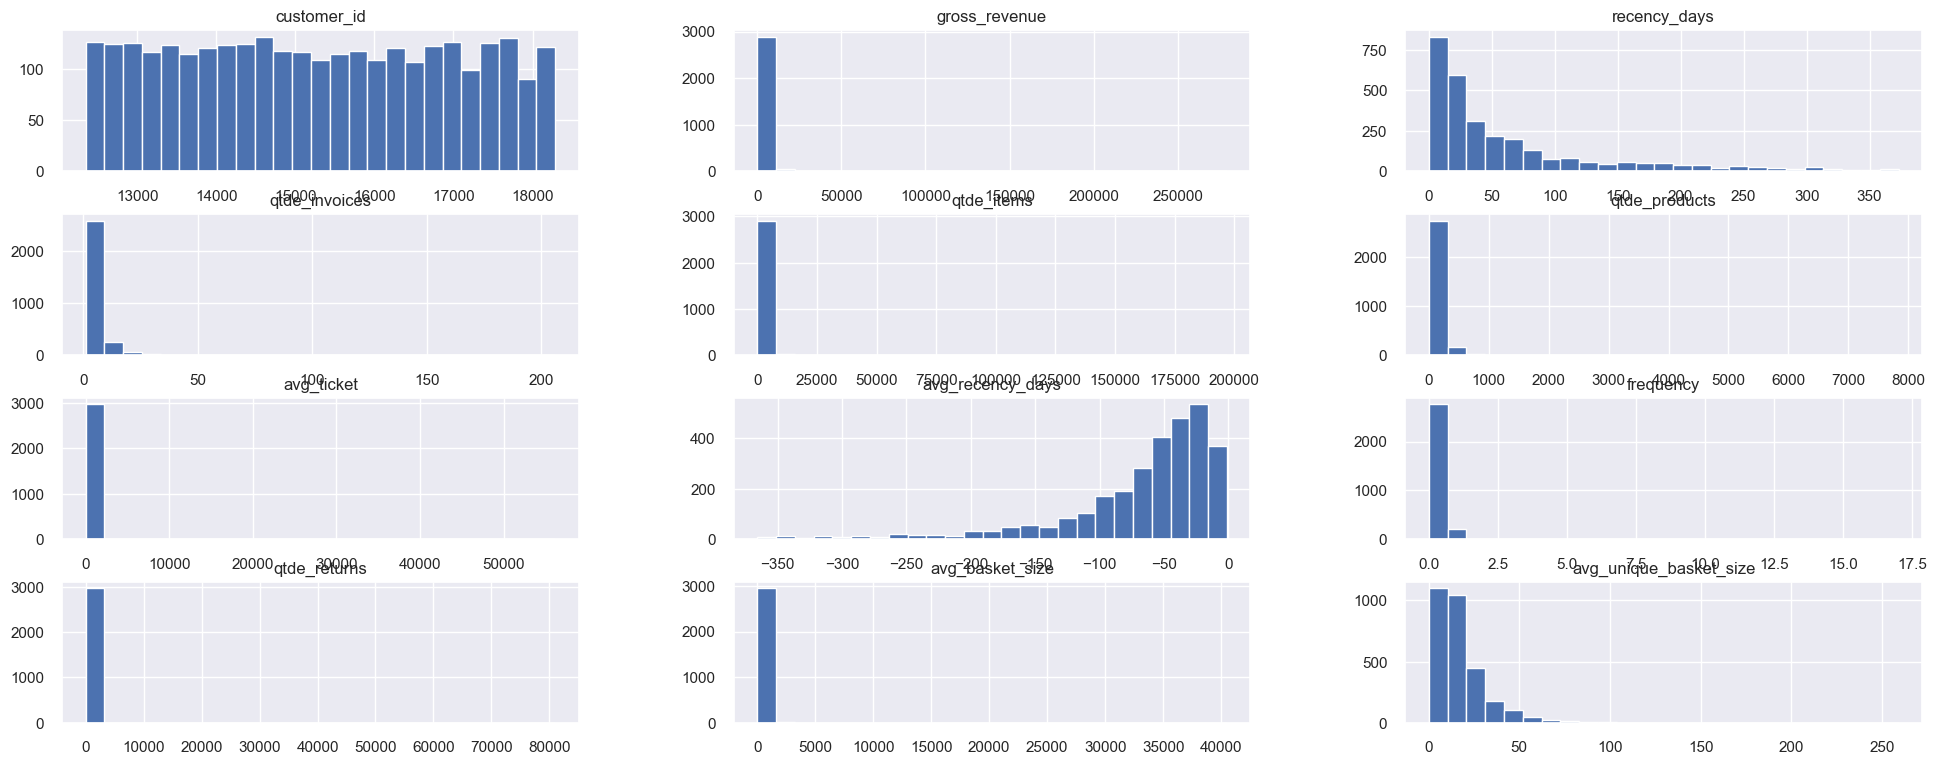

In [47]:
df4.hist( bins=25 )

Pontos importantes:
- Frequency possui baixa variância
- Avg Ticket possui baixa variância

## 4.3. Estudo do Espaço

In [48]:
# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[ cols_selected ].copy() 

In [49]:
df43.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,17850,5391.21,372.0,297.0,17.000000,40.0
1,13047,3232.59,56.0,171.0,0.028302,35.0
2,12583,6705.38,2.0,232.0,0.040323,50.0
3,13748,948.25,95.0,28.0,0.017921,0.0
4,15100,876.00,333.0,3.0,0.073171,22.0


In [50]:
mm = pp.MinMaxScaler()
# 

df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days']           = mm.fit_transform( df43[['recency_days']] )
#df43['qtde_invoices']          = mm.fit_transform( df43[['qtde_invoices']])
#df43['qtde_items']             = mm.fit_transform( df43[['qtde_items']])
df43['qtde_products']          = mm.fit_transform( df43[['qtde_products']])
#df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']])
#df43['avg_recency_days']       = mm.fit_transform( df43[['avg_recency_days']])
df43['frequency']              = mm.fit_transform( df43[['frequency']])
df43['qtde_returns']           = mm.fit_transform( df43[['qtde_returns']])
#df43['avg_basket_size']        = mm.fit_transform( df43[['avg_basket_size']])
#df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']] )


X = df43.copy()

### 4.3.1 PCA

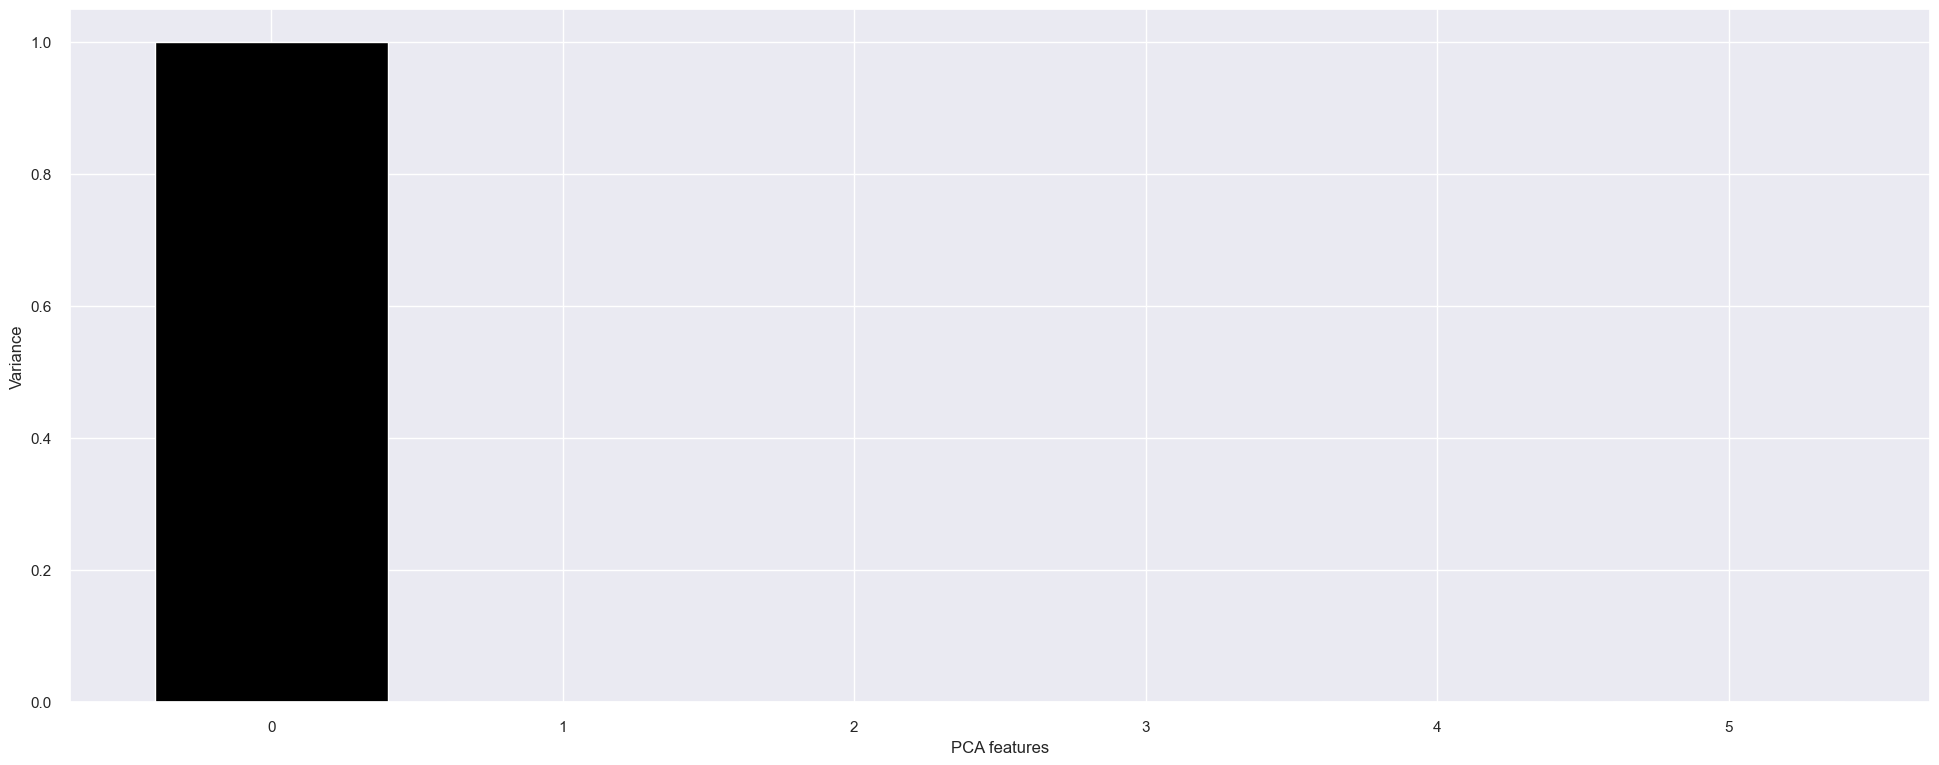

In [51]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )
plt.xlabel('PCA features')
plt.ylabel('Variance')
plt.xticks(features)

# pca component
df_pca = pd.DataFrame( principal_components )

<Axes: xlabel='0', ylabel='1'>

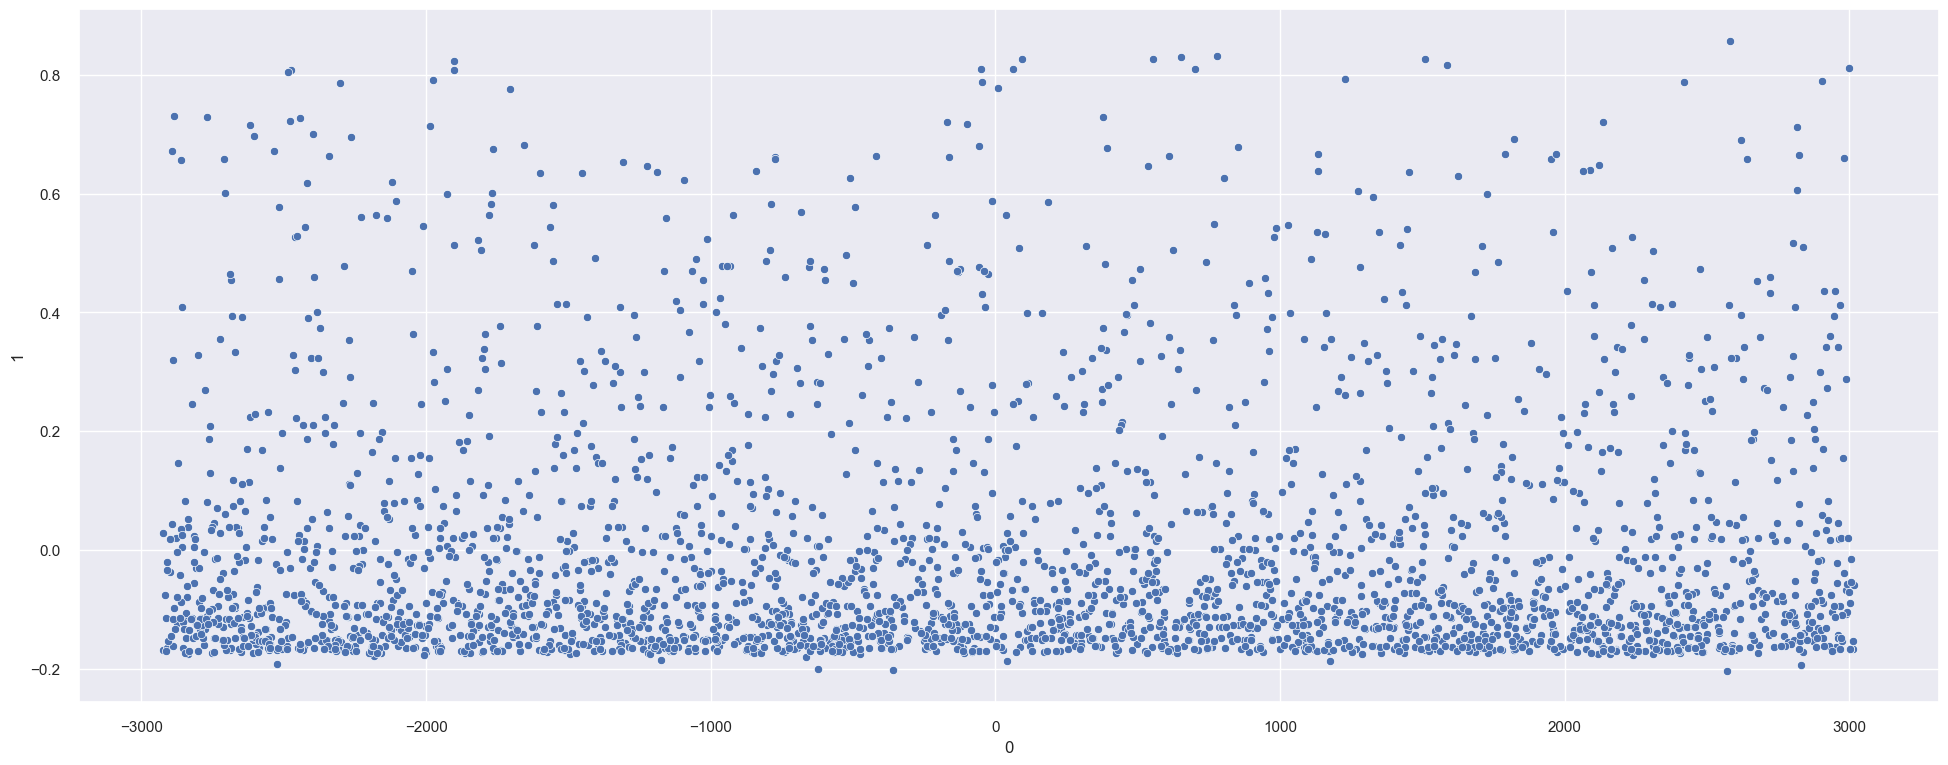

In [52]:
sns.scatterplot( x=0, y=1, data=df_pca ) 

### 4.3.2. UMAP

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

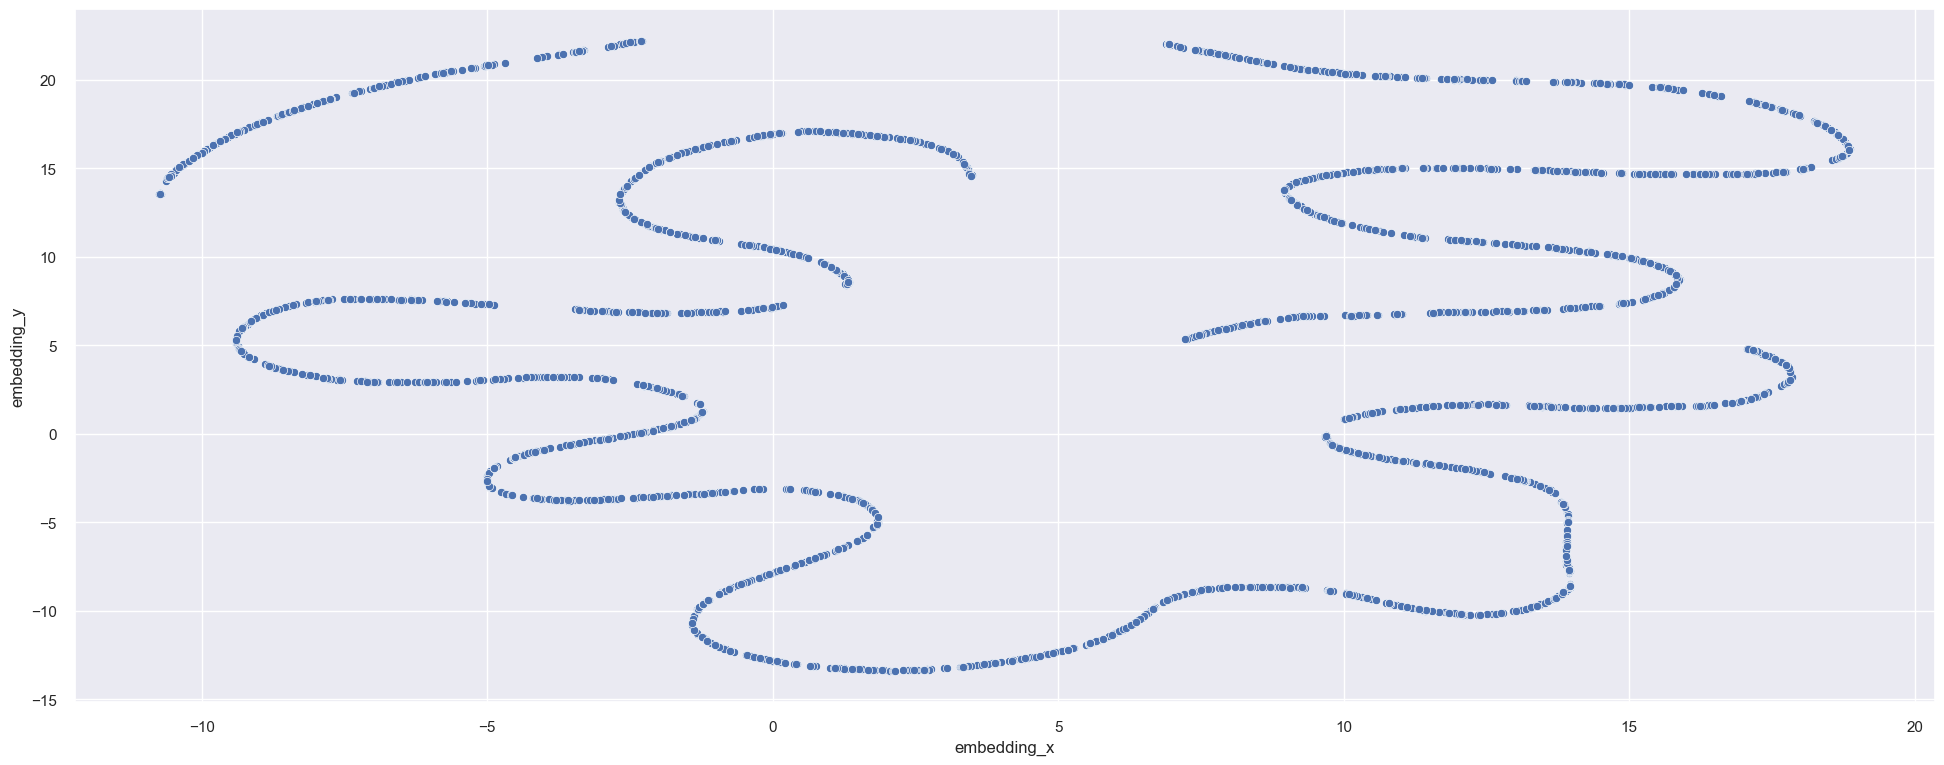

In [53]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 4.3.2. t-SNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

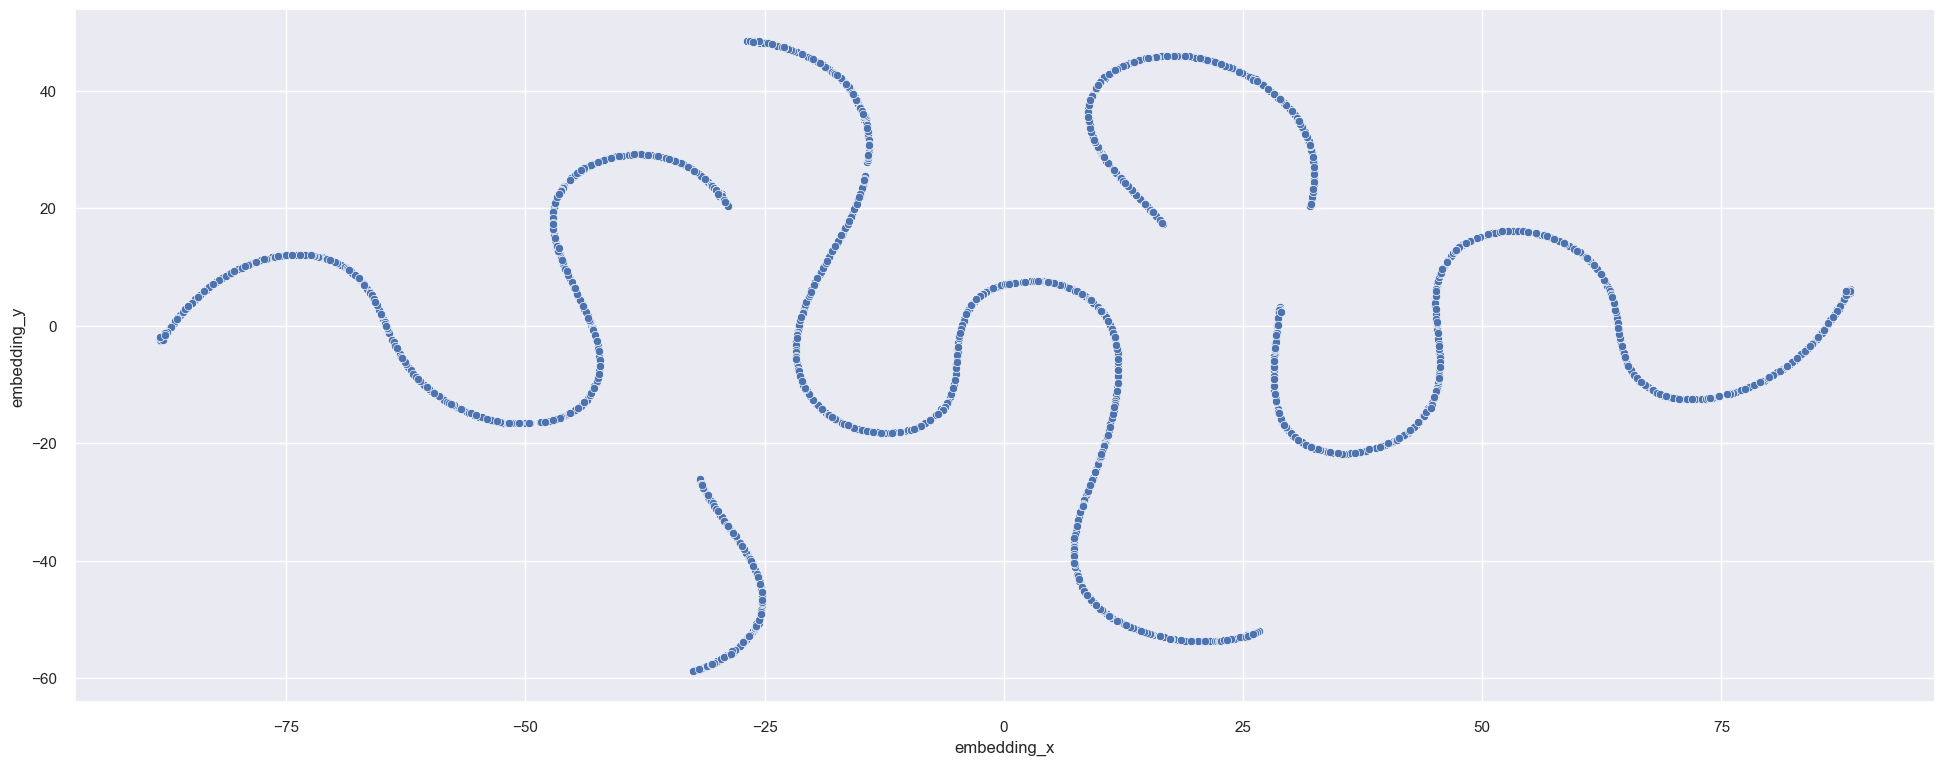

In [54]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 4.3.3. Tree-Based Embedding

In [55]:
# training dataset
X = df4.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 

# dataframe Leaf

RandomForestRegressor(random_state=42)

In [56]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

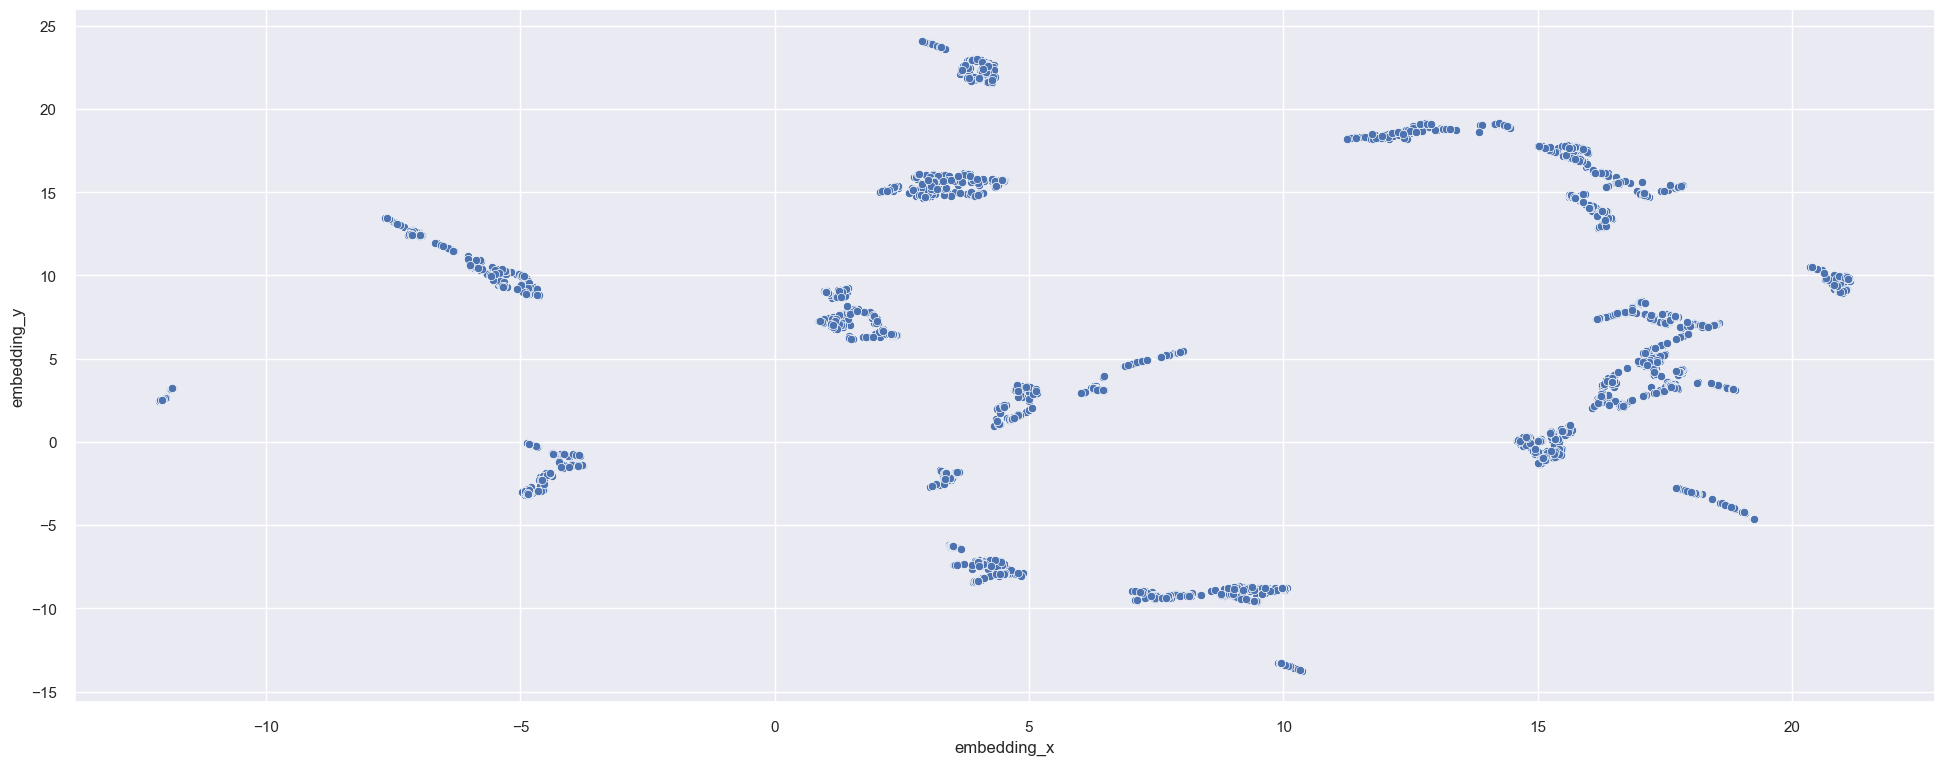

In [57]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

# 5.0 Data Preparation

In [58]:
#df5 = df4.copy()
df5 = df_tree.copy()

In [61]:
## Standard Scalaer
# ss = pp.StandardScaler()

# df5['gross_revenue'] = mm.fit_transform( df5[['gross_revenue']] )
# df5['recency_days'] = mm.fit_transform( df5[['recency_days']] )
# df5['qtde_invoices'] = mm.fit_transform( df5[['qtde_invoices']] )
# df5['qtde_items'] = mm.fit_transform( df5[['qtde_items']] )
# df5['avg_ticket'] = mm.fit_transform( df5[['avg_ticket']] )
# df5['avg_recency_days'] = mm.fit_transform( df5[['avg_recency_days']] )
# df5['frequency'] = mm.fit_transform( df5[['frequency']] )
# df5['qtde_returns'] = mm.fit_transform( df5[['qtde_returns']] )
# df5['avg_basket_size'] = mm.fit_transform( df5[['avg_basket_size']] )
# df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )

In [60]:
df5.head()

,embedding_x,embedding_y
0,2.936908,24.057112
1,2.799330,15.804017
2,-6.362591,11.537782
3,19.031134,-4.189617
4,17.103661,14.948697


# 6.0 Feature Selection 

In [62]:
#df6 = df5.copy()
df6 = df_tree.copy()

# 7.0 Hyperparameter Fine-Tunning 

In [63]:
#X = df6.drop(columns=['customer_id'])
X = df_tree.copy()

In [64]:
X.head()

,embedding_x,embedding_y
0,2.936908,24.057112
1,2.799330,15.804017
2,-6.362591,11.537782
3,19.031134,-4.189617
4,17.103661,14.948697


In [66]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1 K-Means

In [67]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

/Users/luishmq/.pyenv/versions/3.8.13/envs/insiders_clustering/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/luishmq/.pyenv/versions/3.8.13/envs/insiders_clustering/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/luishmq/.pyenv/versions/3.8.13/envs/insiders_clustering/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/luishmq/.pyenv/versions/3.8.13/envs/insiders_clustering/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The defaul

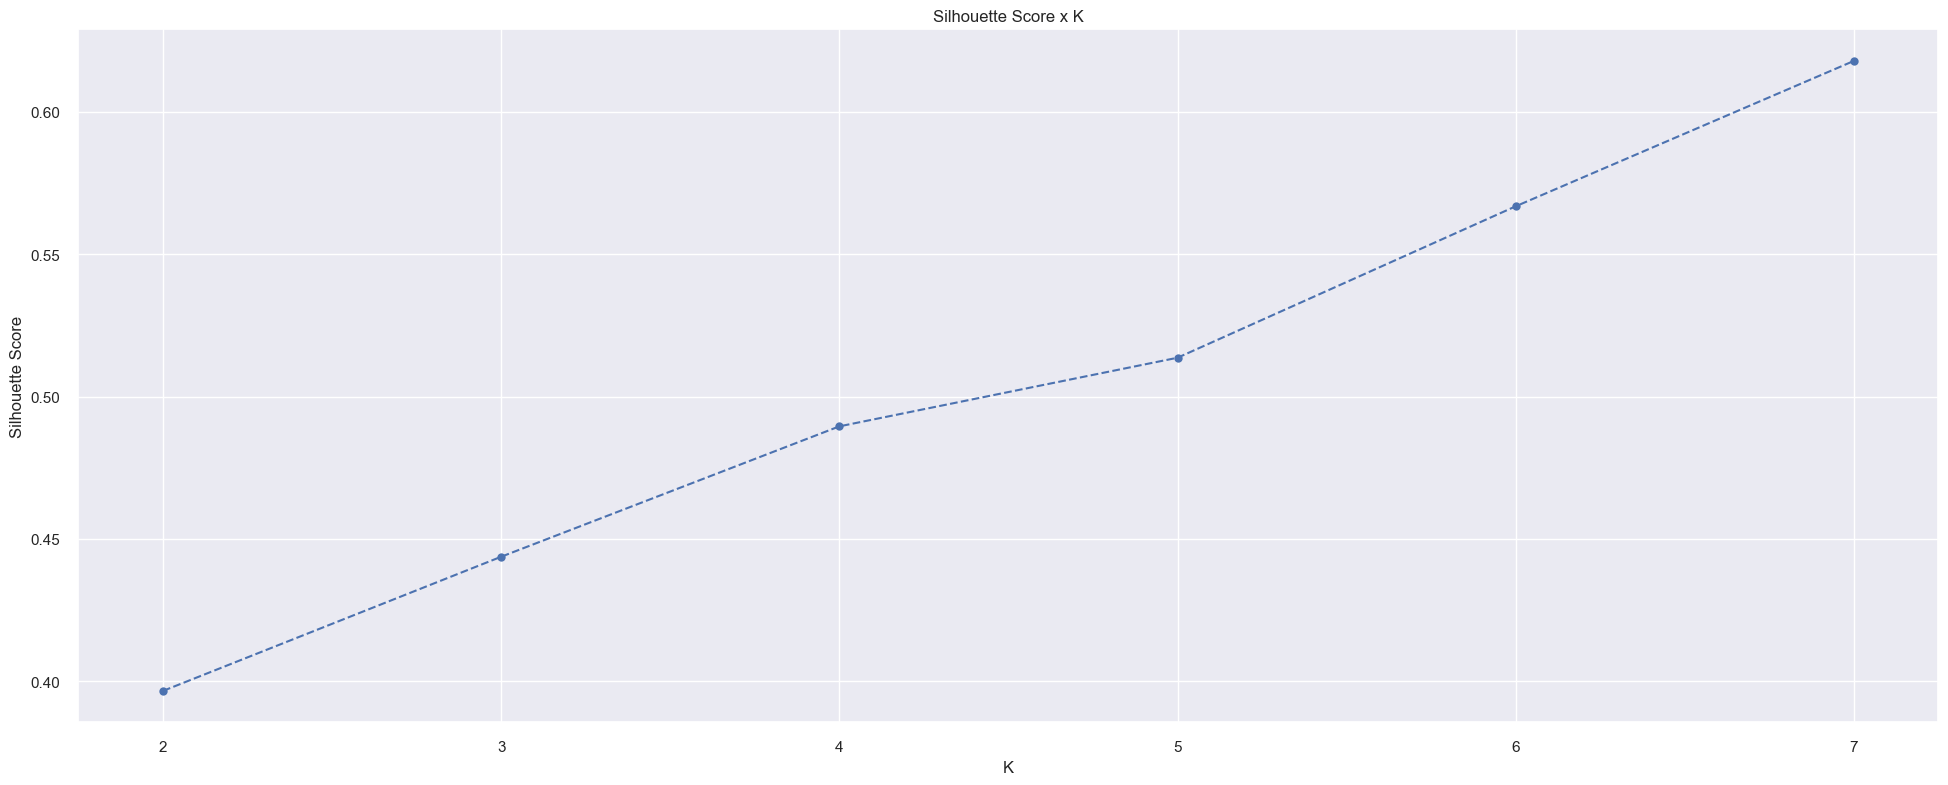

In [68]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

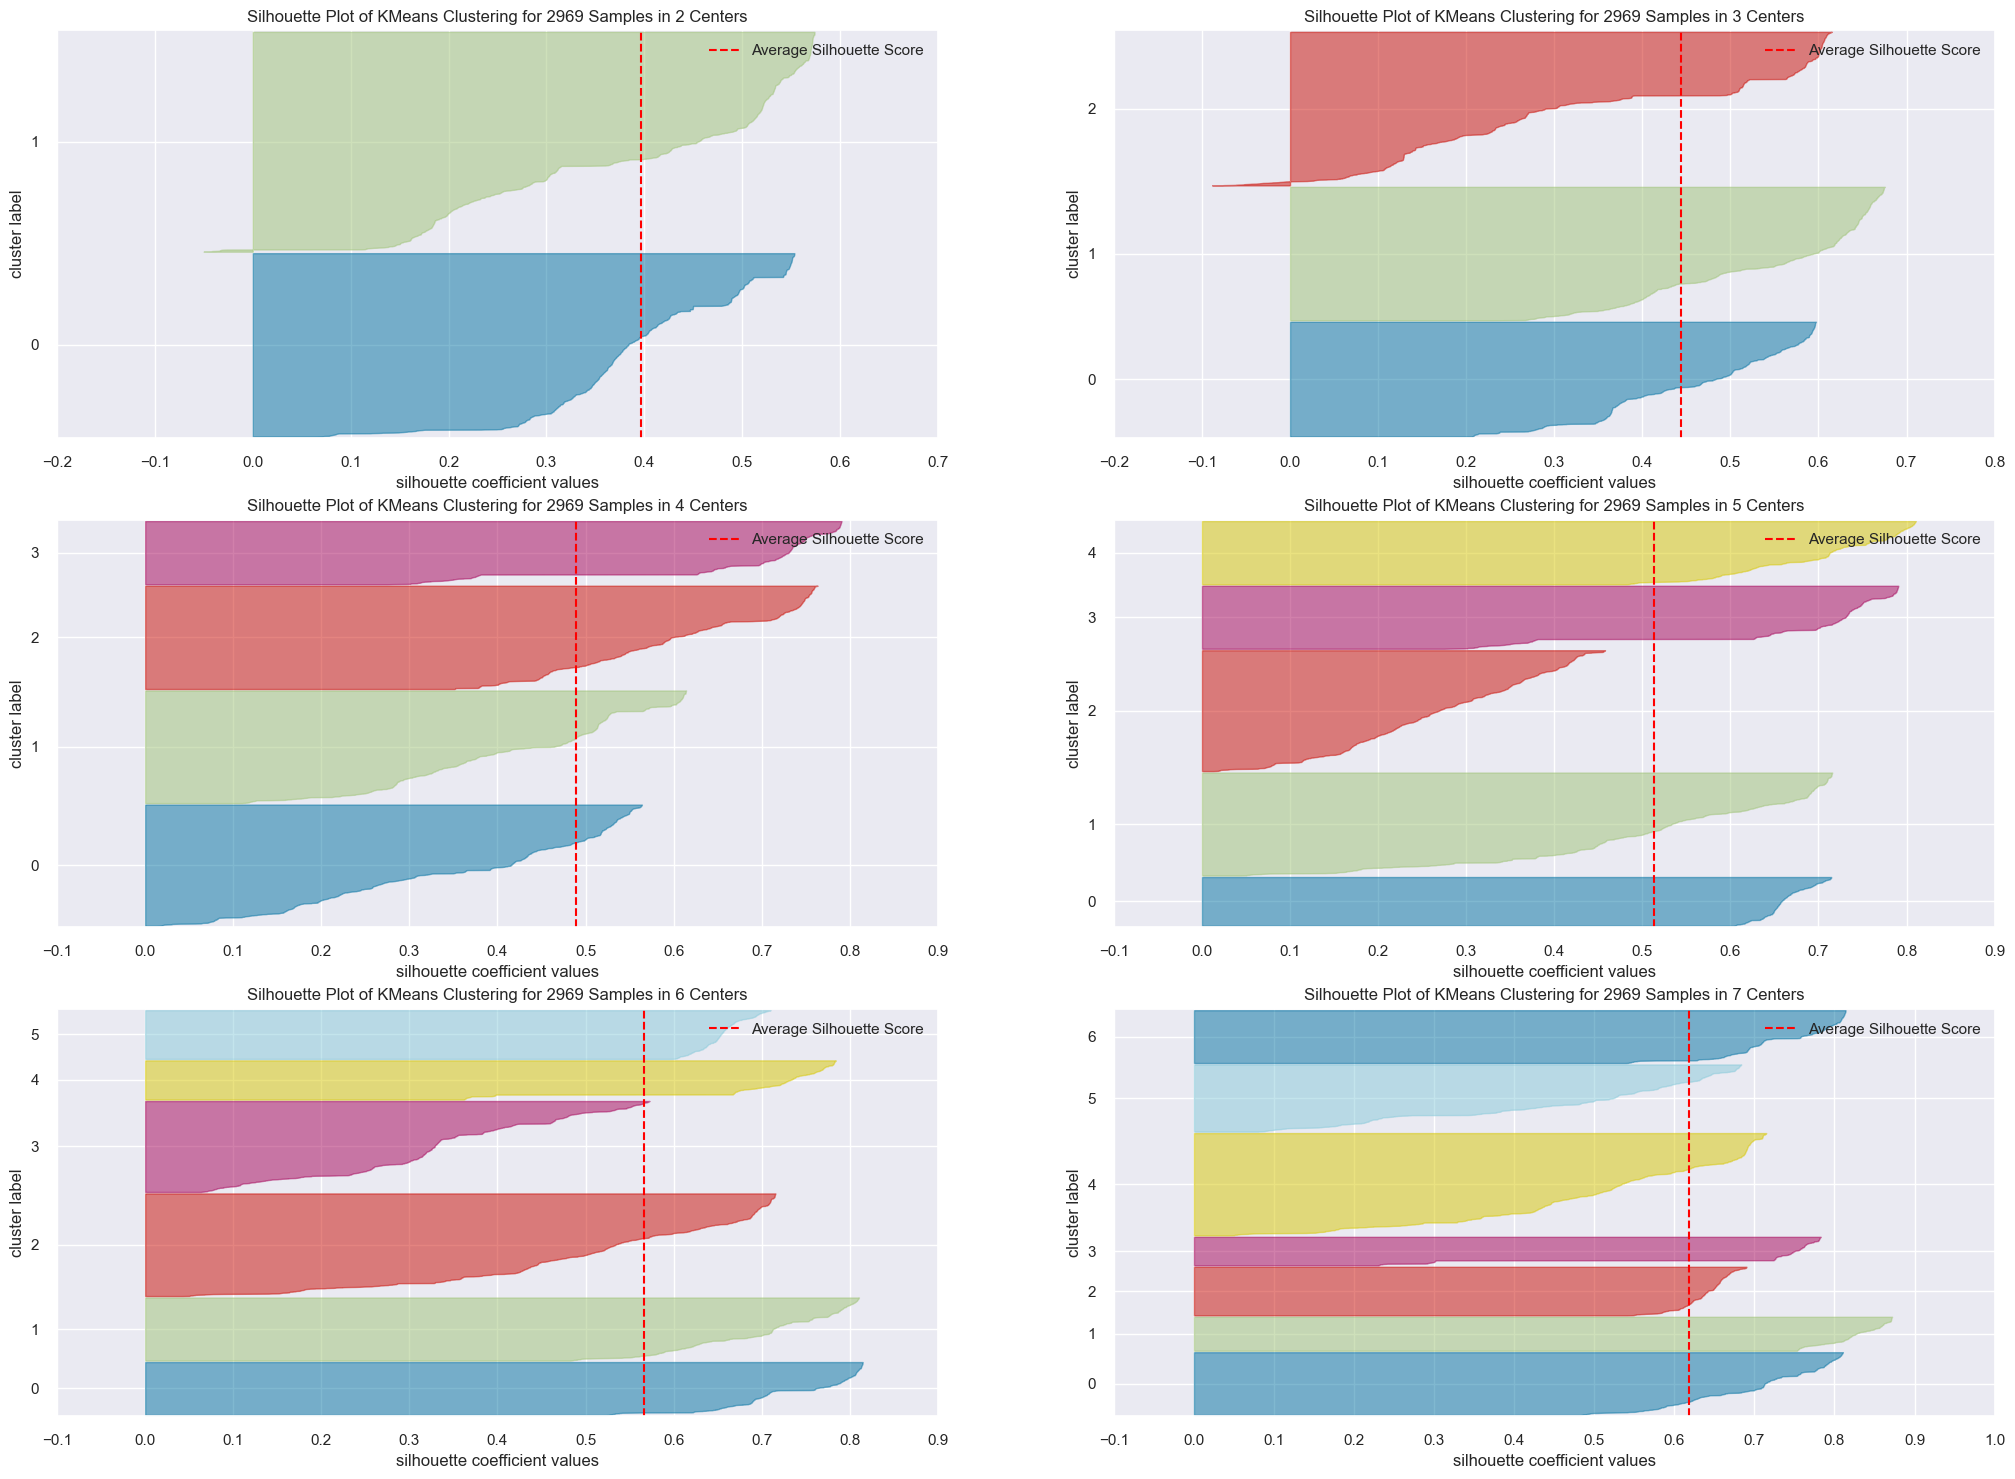

In [120]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))
                      
for k in clusters:
    # Model definition
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

## 7.2 GMM

In [69]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

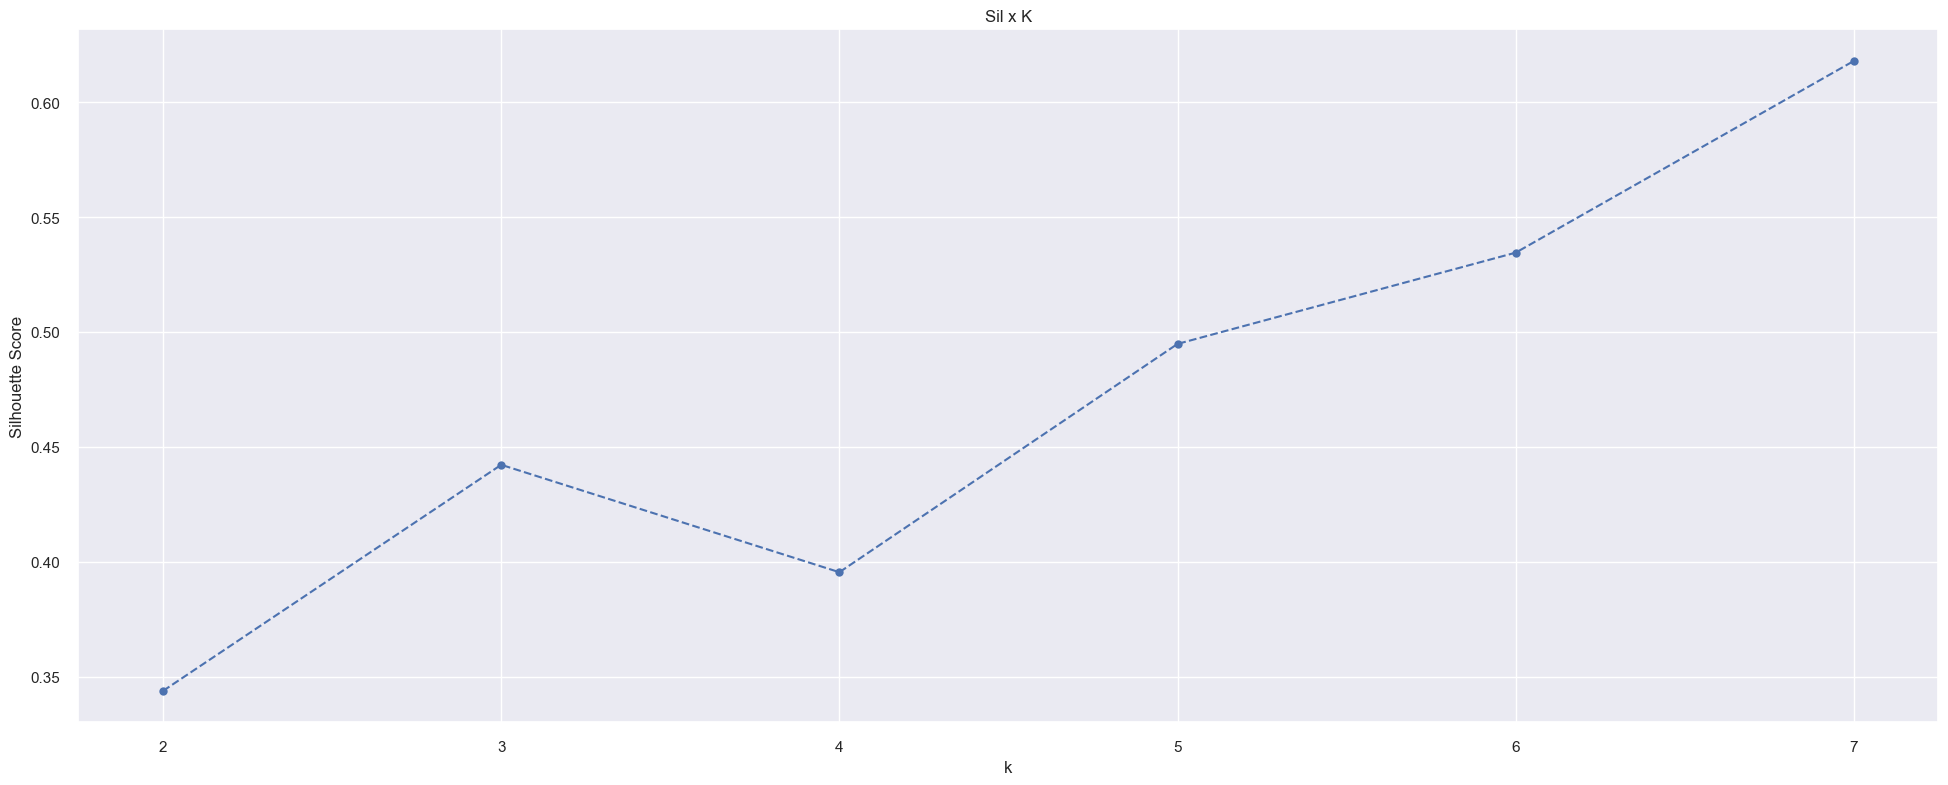

In [70]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.3 Hierarchical Clustering

### 7.3.1. HClustering Silhouette Score

In [71]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

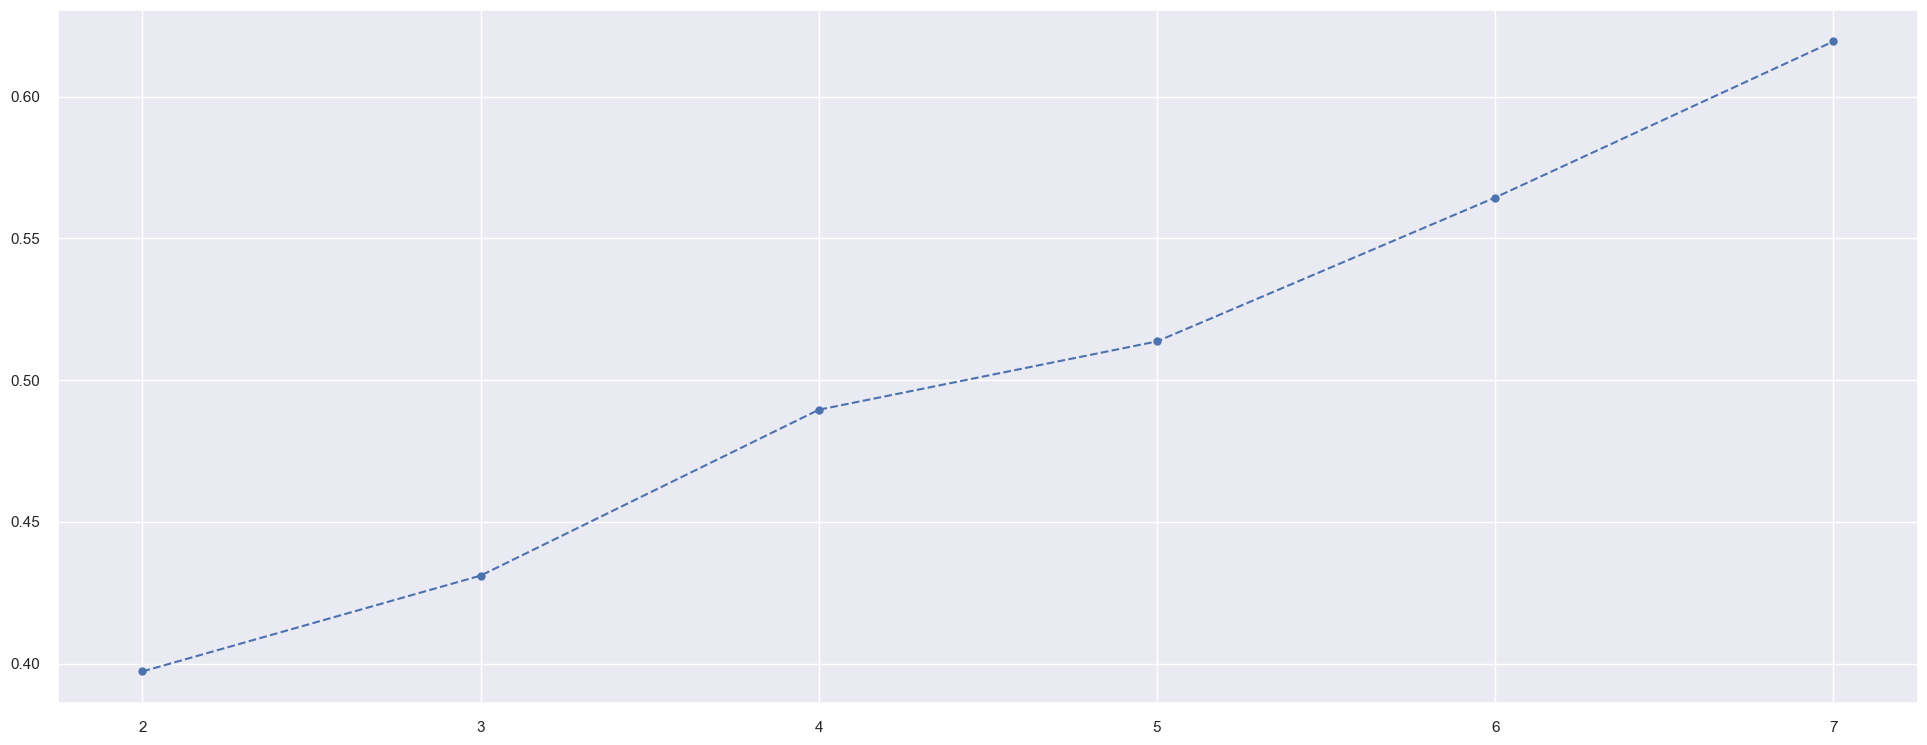

In [72]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

[]

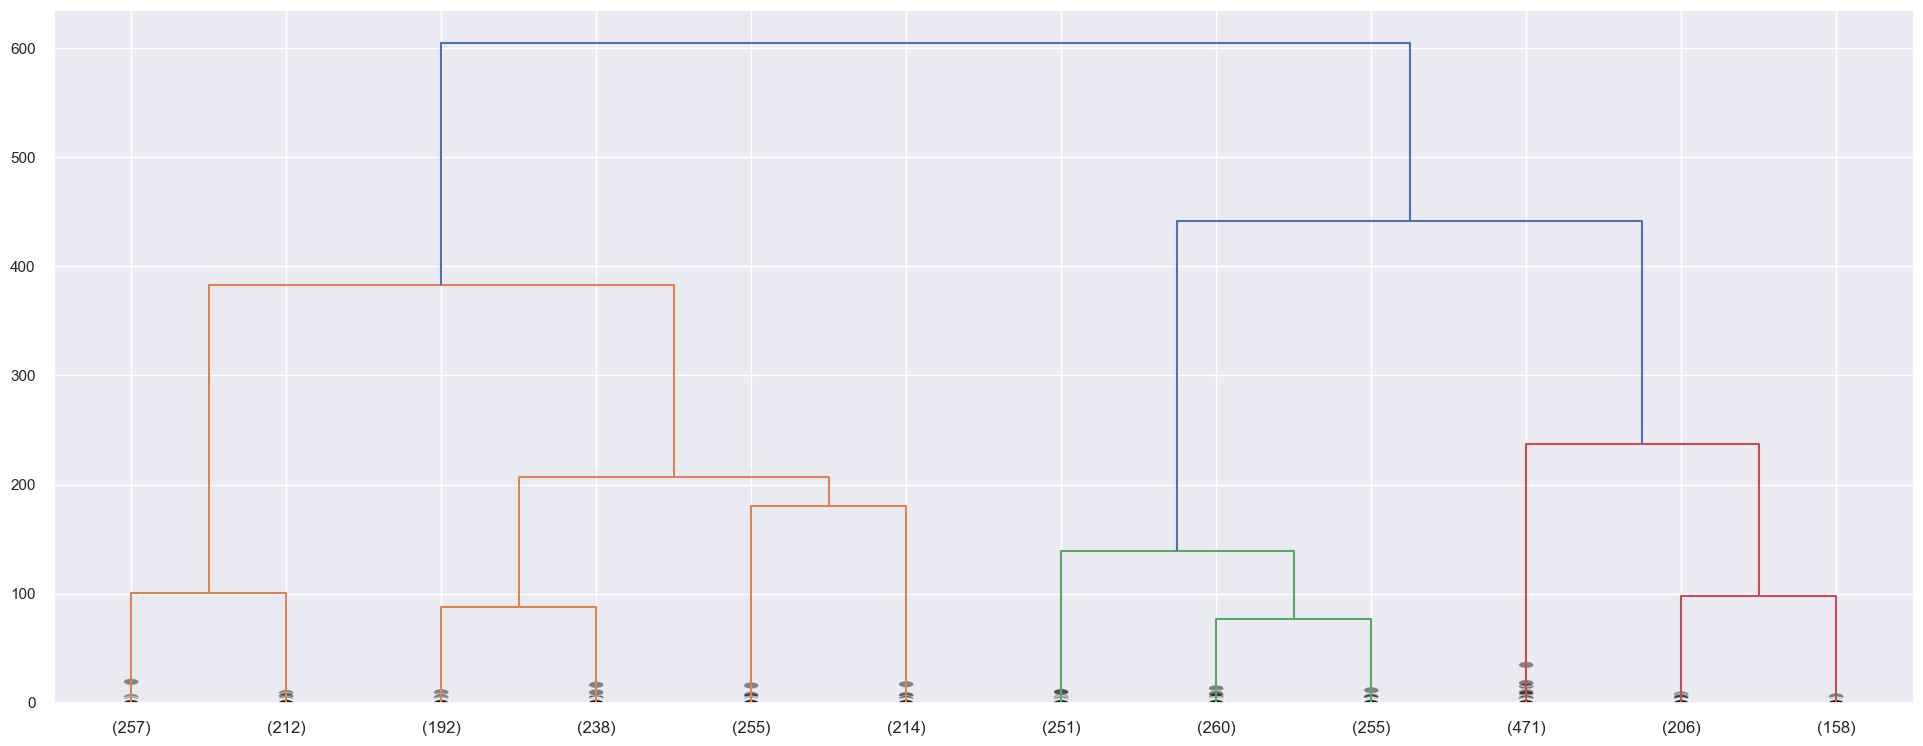

In [73]:
 #truncated dendrogram
hc.dendrogram(
    hc_model,
    #leaf_rotation=90,
    #leaf_font_size=8,
    truncate_mode='lastp',#take out for complete (heavy)
    p=12, #truncate after 12 
    show_contracted=True
)
plt.plot()

## 7.4. DBSCAN

In [74]:
eps=2.00
min_samples=20 

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( unique( labels ) ) ) )
print( unique( labels ) )

Silhouette Score: 0.6502450108528137
Number of Clusters: 15
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [75]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

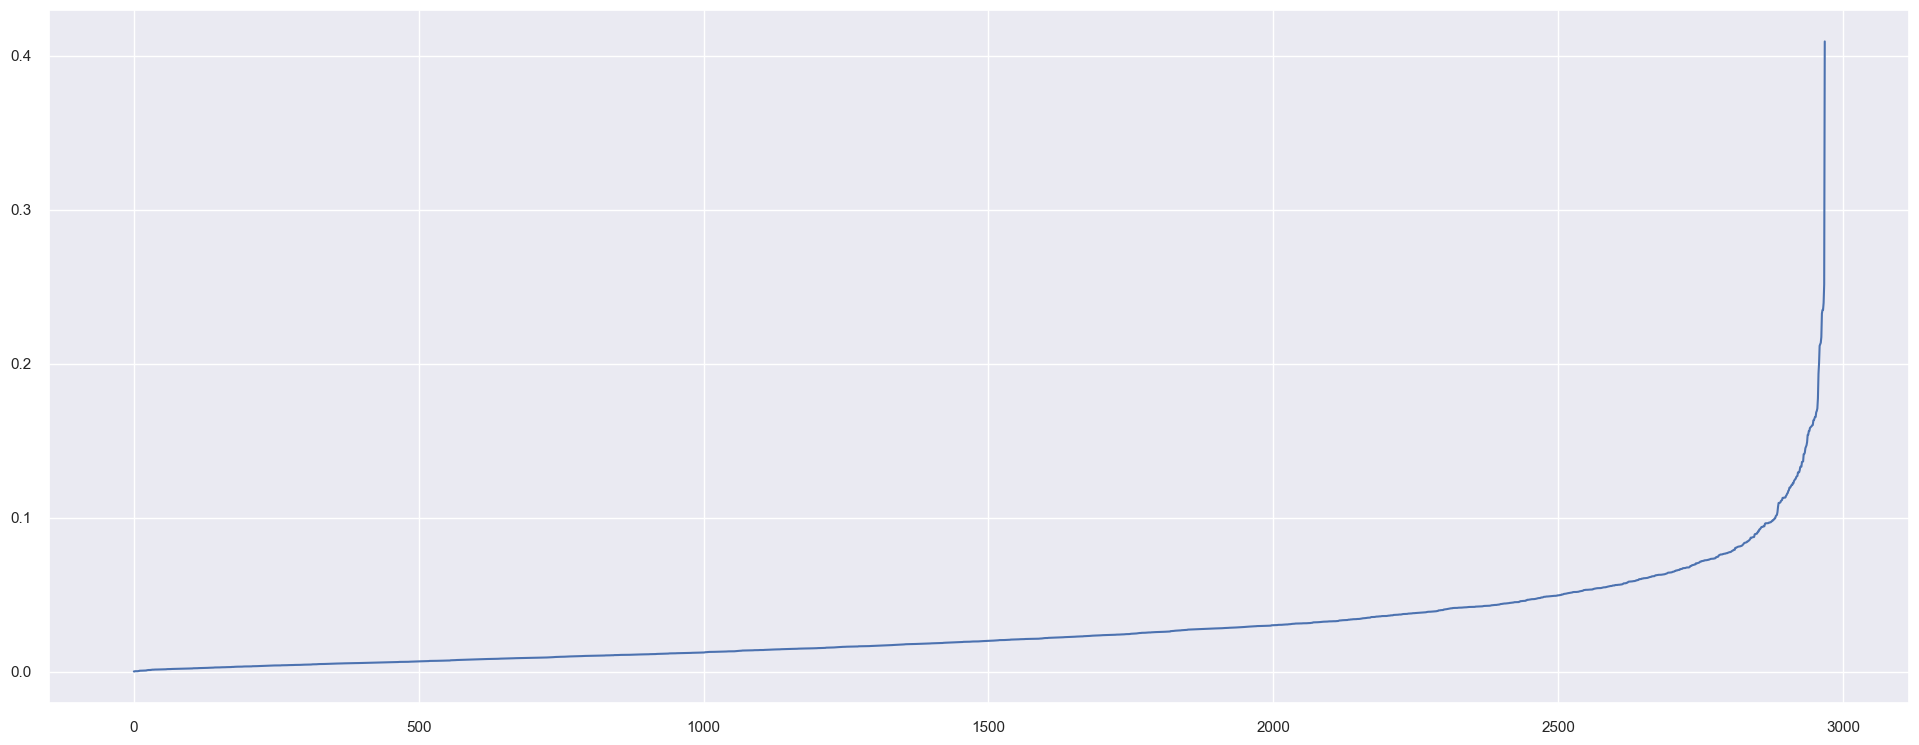

In [76]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

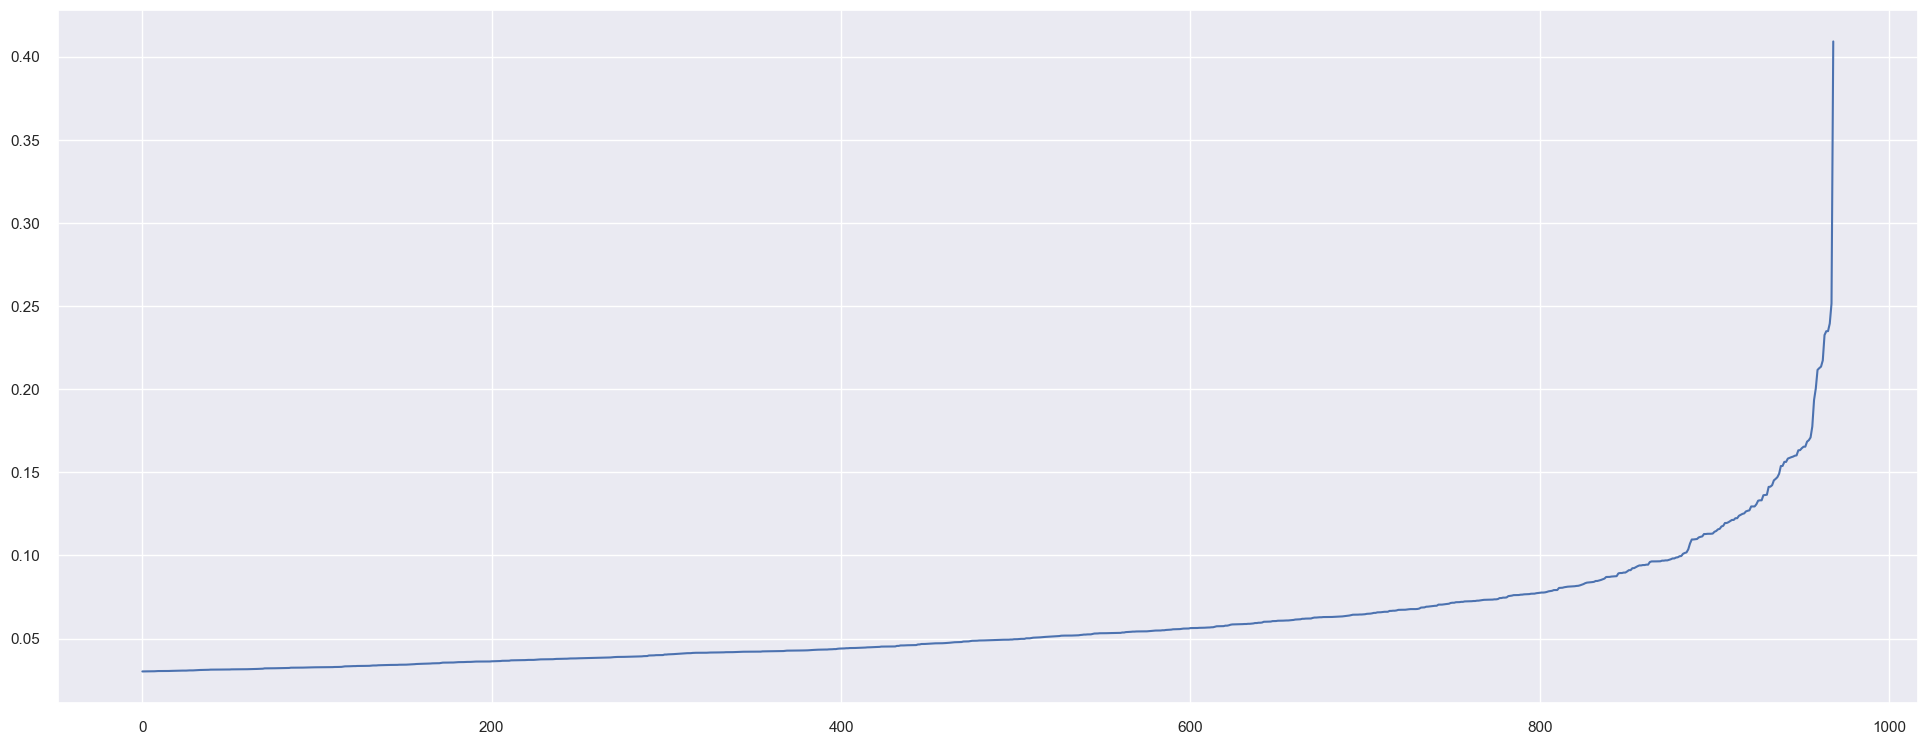

In [77]:
plt.plot( distances[2000:] ) 

In [80]:
dbscan_list = [ 0.6502450108528137, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5 Results

In [81]:
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list,
     'DBSCAN': dbscan_list}
).T

df_results.columns = clusters

In [83]:
df_results.style.highlight_max( color='lightgreen', axis=1 ) 

,2,3,4,5,6,7
KMeans,0.396615,0.443741,0.489540,0.513642,0.566841,0.617908
GMM,0.343963,0.442272,0.395566,0.494848,0.534532,0.617908
HC,0.397248,0.431053,0.489540,0.513642,0.564373,0.619418
DBSCAN,0.650245,0.000000,0.000000,0.000000,0.000000,0.000000


## 7.6 Silhouette Analysis

 For K = 2. Silhouette Score: 0.39724820852279663


/var/folders/wt/4bhdq9gj4vnbrm086fldm7z80000gn/T/ipykernel_1534/1276605679.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap( 'Spectral' )


 For K = 3. Silhouette Score: 0.43105348944664


/var/folders/wt/4bhdq9gj4vnbrm086fldm7z80000gn/T/ipykernel_1534/1276605679.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap( 'Spectral' )


 For K = 4. Silhouette Score: 0.4895399510860443


/var/folders/wt/4bhdq9gj4vnbrm086fldm7z80000gn/T/ipykernel_1534/1276605679.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap( 'Spectral' )


 For K = 5. Silhouette Score: 0.5136424899101257


/var/folders/wt/4bhdq9gj4vnbrm086fldm7z80000gn/T/ipykernel_1534/1276605679.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap( 'Spectral' )


 For K = 6. Silhouette Score: 0.5643730163574219


/var/folders/wt/4bhdq9gj4vnbrm086fldm7z80000gn/T/ipykernel_1534/1276605679.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap( 'Spectral' )


 For K = 7. Silhouette Score: 0.6194179654121399


/var/folders/wt/4bhdq9gj4vnbrm086fldm7z80000gn/T/ipykernel_1534/1276605679.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap( 'Spectral' )


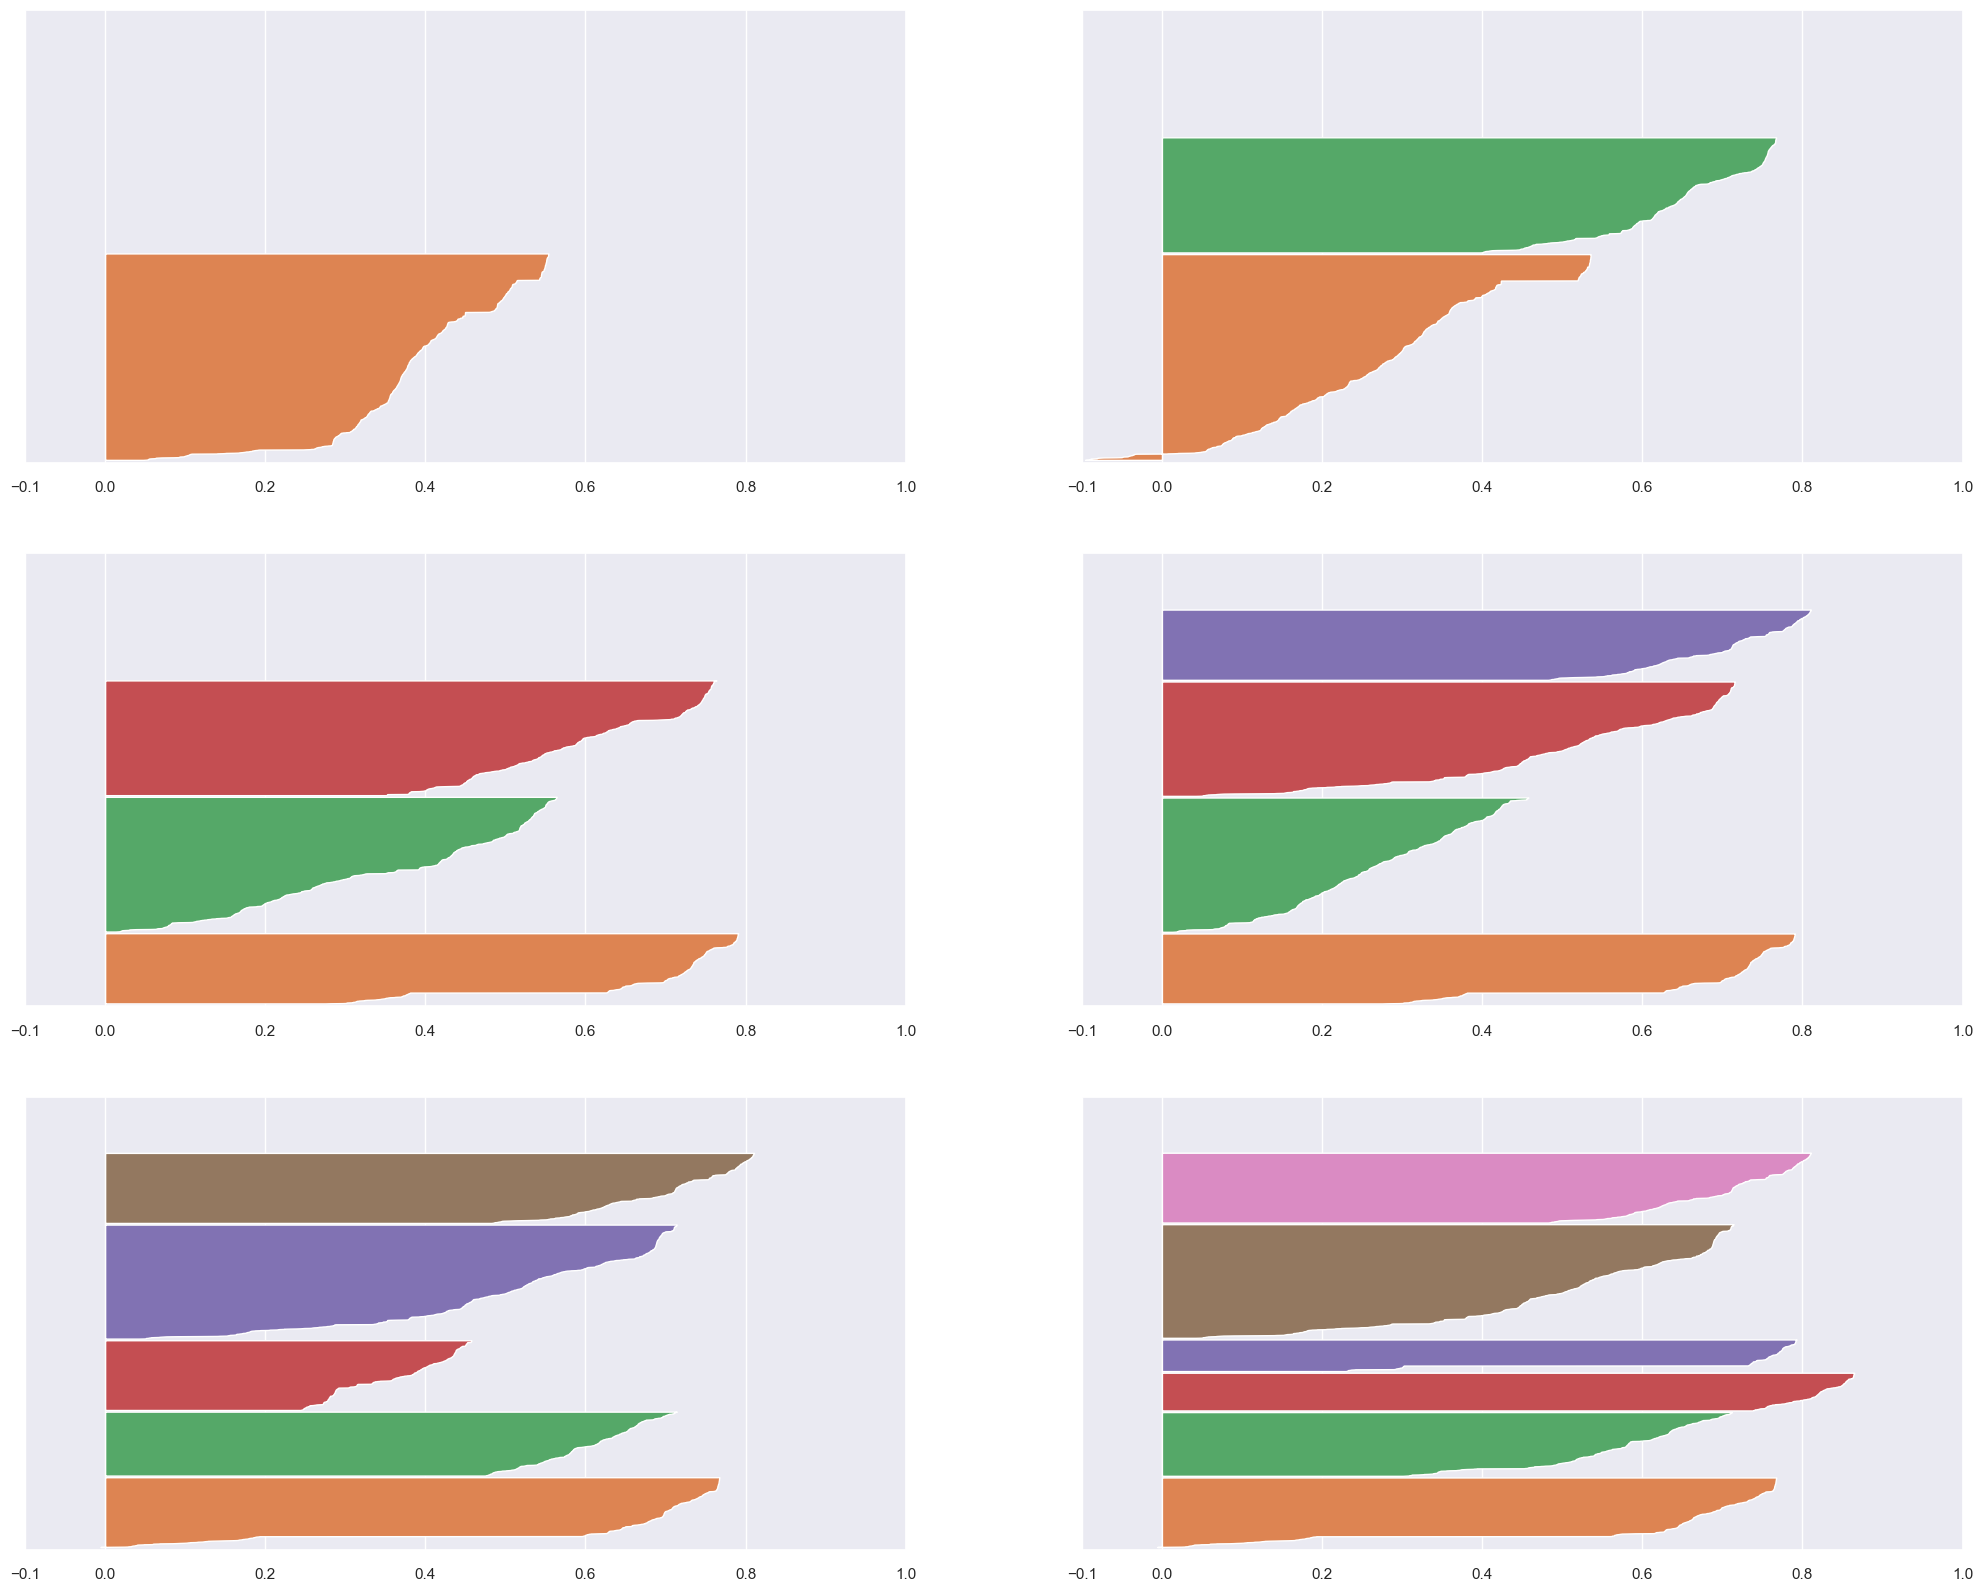

In [84]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    samples_silhouette_values = silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 8.0 Model Training 

## 8.1 Final model

In [91]:
# model definition
k = 7

In [94]:
# model definition & training
hc_model = hc.linkage( X, 'ward' )

# model predict
labels = hc.fcluster( hc_model, k, criterion='maxclust' )

## 8.2 Cluster Validation

In [95]:
print( 'SS value: {}'.format( silhouette_score( X, labels, metric='euclidean' ) ) ) 

SS value: 0.6194179654121399


# 9.0 Cluster Analysis 

In [96]:
df9 = X.copy()
df9['cluster'] = labels

## 9.1 Visualization Inspection

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

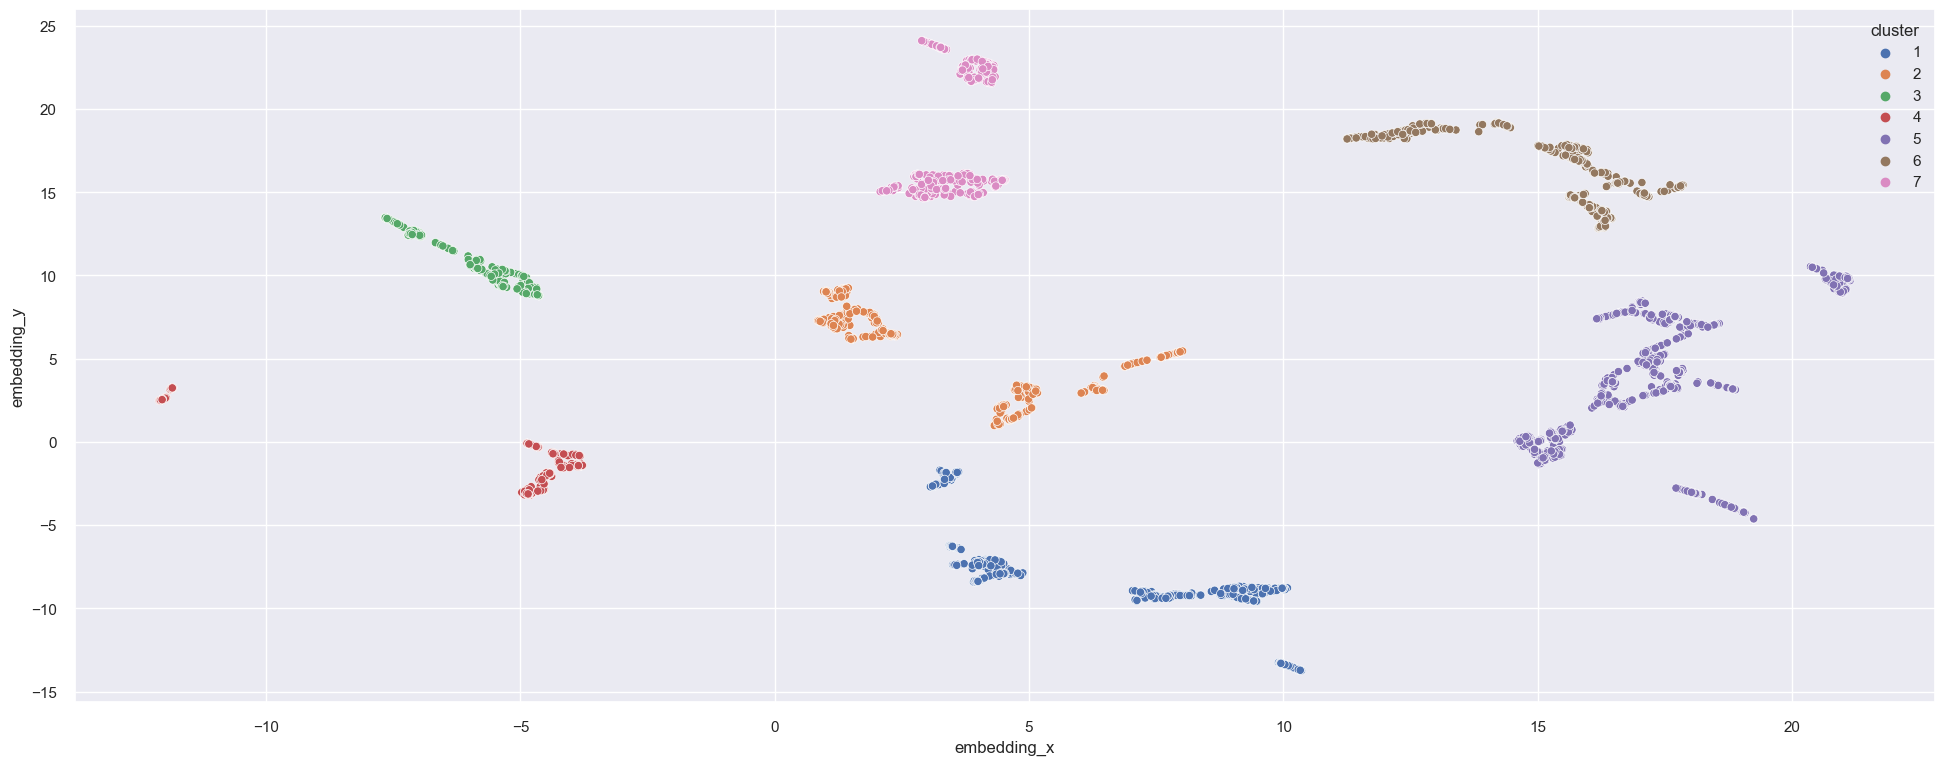

In [97]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

In [98]:
df9.head()

,embedding_x,embedding_y,cluster
0,2.936908,24.057112,7
1,2.799330,15.804017,7
2,-6.362591,11.537782,3
3,19.031134,-4.189617,5
4,17.103661,14.948697,6


## 9.2 2d plot

In [99]:
#df_viz = df9.drop( columns='customer_id', axis=1 )

## 9.3 UMAP

In [100]:
#reducer = umap.UMAP( n_neighbors=90, random_state=42 )
#embedding = reducer.fit_transform( X )

# embedding
#df_viz['embedding_x'] = embedding[:, 0]
#df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
#sns.scatterplot( x='embedding_x', y='embedding_y', 
#                 hue='cluster', 
#                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
#                 data=df_viz )

## 9.4 Cluster Profile

In [101]:
df92 = df4[ cols_selected ].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,7
1,13047,3232.59,56.0,171.0,0.028302,35.0,7
2,12583,6705.38,2.0,232.0,0.040323,50.0,3
3,13748,948.25,95.0,28.0,0.017921,0.0,5
4,15100,876.00,333.0,3.0,0.073171,22.0,6


In [102]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_qtde_products = df92[['qtde_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

df_cluster.sort_values( 'gross_revenue', ascending=False )

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
3,4,214,7.207814,15332.316168,25.009346,382.074766,0.054338,619.668224
2,3,255,8.588750,7760.927451,22.698039,336.725490,0.076508,81.882353
6,7,364,12.260020,2589.838654,40.629121,161.373626,0.085713,22.862637
1,2,430,14.482991,1768.782605,36.190698,118.804651,0.034748,22.188372
0,1,469,15.796564,1119.968827,66.326226,75.754797,0.072525,13.089552
4,5,766,25.799933,673.662415,81.421671,53.523499,0.118968,5.878590
5,6,471,15.863927,335.489214,118.690021,22.048832,0.287561,5.414013


- Cluster 4 ( Champions ): Os melhores clientes, que compraram mais recentemente, com mais frequência e gastam muito. Recompense esses clientes. Eles podem se tornar os primeiros a adotar novos produtos e ajudarão a promover sua marca.

# 10.0 Exploratory Data Analysis

In [103]:
df10 = df92.copy()

In [104]:
df10.head() 

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,7
1,13047,3232.59,56.0,171.0,0.028302,35.0,7
2,12583,6705.38,2.0,232.0,0.040323,50.0,3
3,13748,948.25,95.0,28.0,0.017921,0.0,5
4,15100,876.00,333.0,3.0,0.073171,22.0,6


## 10.1 MindMap de hipoteses

- Fenômeno
- Entidades ( Customer, Location, Finace, Family )
- Caracteristicas da Entidade ( Customer=Nome, Idade, salário, escolaridade )

## 10.2 Hipóteses de Negócio

- Afirmação
- Comparação entre variáveis
- Valor base de comparação

## 10.3 Hipóteses Compra

1. Os clientes do grupo VIP usam cartão de crédito em 80% das compras
2. Os clientes do grupo VIP possuem um ticket médio de 10% acima do cluster More Products
3. Os clientes do grupo VIP possuem um basket size acima de 5 produtos
4. Os clientes do grupo VIP possuem um volume (produtos) de compras acima de 10% do total de compras
5. Os clientes do grupo VIP possuem um volume (faturamento) de compras acima de 10% do total de compras
6. Os clientes do grupo VIP tem um número de devolução abaixo da média da base total de clientes
7. A mediana do faturamento pelos clientes do grupo VIP é 10% maior do que a mediana do faturamento geral
8. O percentil do gmv pelos clientes do grupo VIP

## H1: Os clientes do grupo VIP possuem um volume (produtos) de compras acima de 10% do total de compras¶
### Verdade: Os clientes do grupo VIP possuem um volume de compra de produtos de 16.12%

In [105]:
# soma da qtde de produtos do insiders
df_sales_insiders = df10.loc[df10['cluster'] == 7, 'qtde_products'].sum()
df_sales_total = df10.loc[:, 'qtde_products'].sum()

# soma da qtde de produtos total
print( '% Sales VIP group: {:.2f}%'.format( 100*df_sales_insiders / df_sales_total ) )

% Sales VIP group: 16.12%


## H2. Os clientes do grupo VIP possuem um volume (faturamento) de compras acima de 10% do total de compras
### Verdadeiro: Os clientes do grupo VIP possuem um volume de GMV de 11.55%

In [106]:
# soma da qtde de produtos do insiders
df_gmv_insiders = df10.loc[df10['cluster'] == 7, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

# soma da qtde de produtos total
print( '% GMV VIP: {:.2f}%'.format( 100*df_gmv_insiders / df_gmv_total ) )

% GMV VIP: 11.55%


## H3. Os clientes do grupo VIP tem um número de devolução médio abaixo da média da base total de clientes
### Verdadeiro: Os clientes do grupo VIP tem a média de devoluções abaixo da média geral

In [115]:
# media de devolucao do cluster insider
df_avg_return_insiders = df10.loc[df10['cluster'] == 7, 'qtde_returns'].mean()

# media de devolucao do total
df_avg_return_all = df10['qtde_returns'].mean()

#
print( 'Avg Return VIP: {} vs Avg Return All:{}'.format( np.round( df_avg_return_insiders, 0 ), 
                                                              np.round( df_avg_return_all, 0 ) ) )

Avg Return VIP: 23.0 vs Avg Return All:62.0


## H4. A mediana do faturamento pelos clientes do grupo VIP é 10% maior do que a mediana do faturamento geral.
### Verdadeiro. A mediana do faturamento é 132.50% acima da média.

In [108]:
# mediana de gmv do insiders
df_median_gmv_insiders = df10.loc[df10['cluster'] == 7, 'gross_revenue'].median()

# mediana de gmv do total
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = ( df_median_gmv_insiders - df_median_gmv_total ) / df_median_gmv_total
print( 'Median Diff: {:.2f}%'.format( 100*gmv_diff ) )

Median Diff: 132.50%


## H5. A GMV dos clientes do grupo VIP está concentrada no 3 quartil
### Falso. O faturamento dos clientes do grupo VIP está concentrada na quartil 1

In [109]:
np.percentile( df10.loc[df10['cluster'] == 7, 'gross_revenue'], q=0.1 )

536.63822

In [110]:
np.percentile( df10.loc[df10['cluster'] == 7, 'gross_revenue'], q=0.9 )

983.7544800000001

<Axes: xlabel='gross_revenue'>

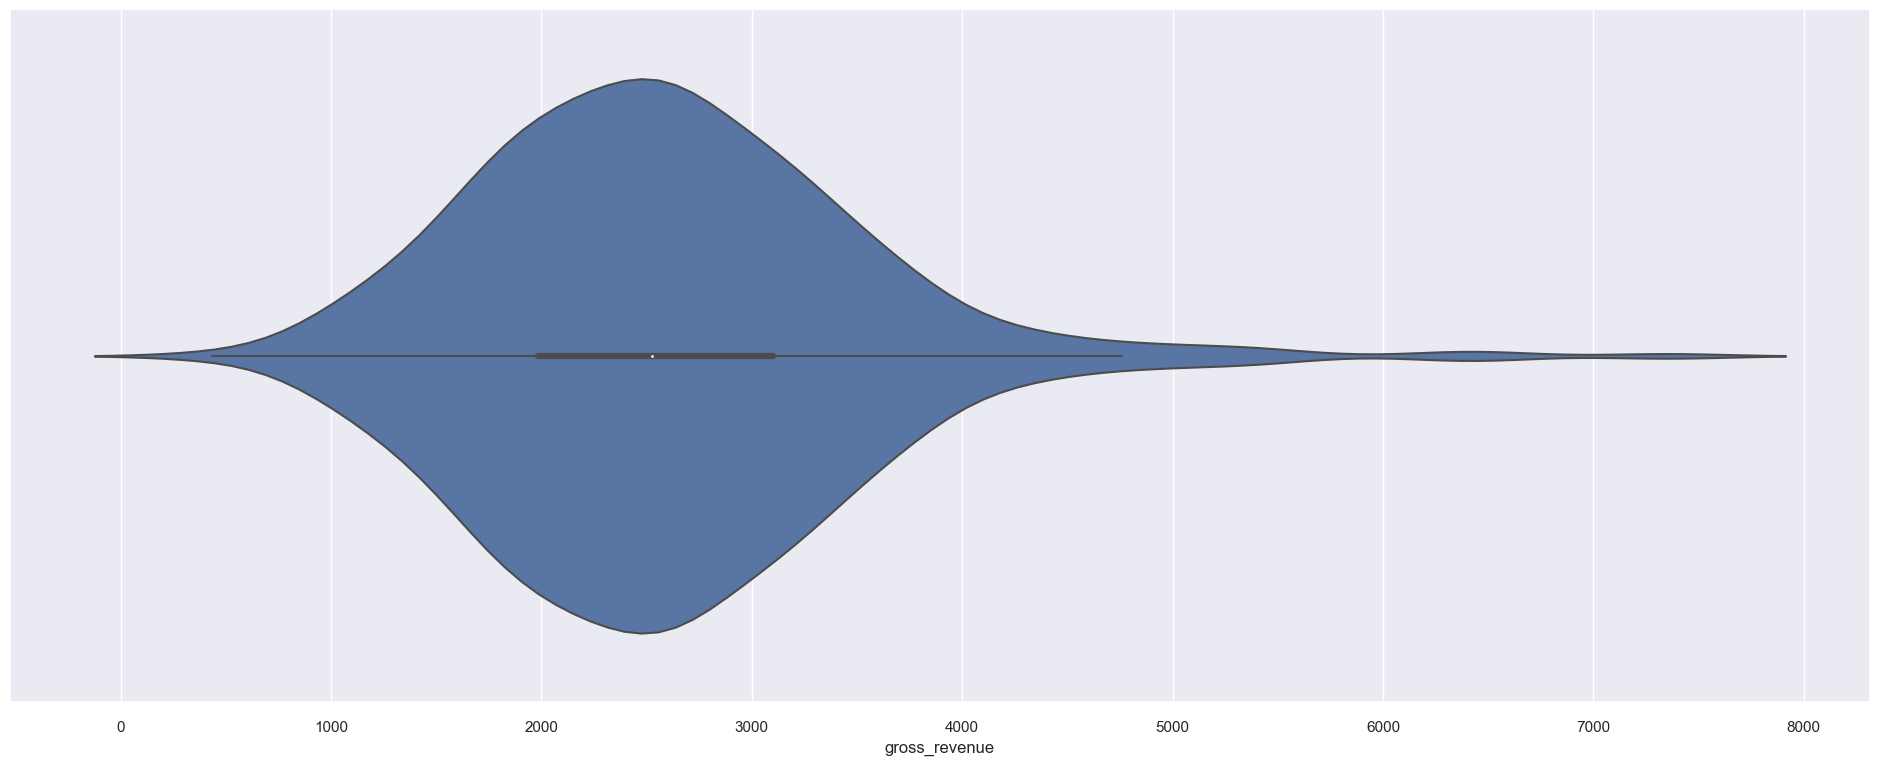

In [111]:
df_aux = df10.loc[(df10['cluster'] == 7) & (df10['gross_revenue'] < 10000 ), 'gross_revenue'];
sns.violinplot( x=df_aux )

## 10.4 Hipóteses Cliente

1. 60% dos clientes do grupo VIP possuem o estado civil de solteiro.
2. 10% dos clientes do grupo VIP estão na faixa de 24-35 anos.
3. 40% das localidades de entrega do grupo VIP estão dentro de um raio de 50km.
4. 5% dos clientes do grupo VIP recebem mais de 100 mil dólares anualmente.
5. 90% dos clientes do grupo VIP tem ensino superior completo.

## 10.5 Hipóteses Produto

1. 30% de todos os produtos em pacotes grandes são comprados pelos clientes do grupo VIP.
2. A mediana dos preços dos produtos comprados pelos clientes do grupo VIP é 10% maior do que a mediana de todos os preços dos produtos.
3. O percentil do preço dos produtos comprados pelos grupo VIP.
4. O peso médio dos produtos comprados pelos clientes do grupo VIP é maior do que o peso médio dos outros clusters.
5. A idade média dos produtos comprados pelos clientes do grupo VIP é menor do que 15 dias.

## 10.6 Perguntas de Negócio

### 1. Quem são as pessoas elegíveis para participar do programa VIP ?

In [112]:
df10.loc[df10['cluster'] == 7, 'customer_id'].head()

0     17850
1     13047
22    13448
35    13758
57    15485
Name: customer_id, dtype: int64

### 2. Quantos clientes farão parte do grupo?

In [113]:
df10.loc[df10['cluster'] == 7, 'customer_id'].size

364

### 3. Quais as principais características desses clientes ?

Cluster VIP
- Número de customers: 471 (16% do customers )
- Faturamento médio: 8836
- Recência média: 21 dias
- Média de Produtos comprados: 424 produtos
- Frequência de Produtos comprados: 0.09 produtos/dia
- Receita em média: $8836.13,00 dólares

### 4. Qual a porcentagem de contribuição do faturamento, vinda do grupo VIP ?

In [114]:
df_insiders_gmv = df10.loc[df10['cluster'] == 7, 'gross_revenue'].sum()
df_all_gmv = df10.loc[:, 'gross_revenue'].sum()

print( '% GMV from Insiders: {}'.format( df_insiders_gmv / df_all_gmv ) )

% GMV from Insiders: 0.1154883915787375


### 5. Qual a expectativa de faturamento desse grupo para os próximos meses?

Não teremos resposta agora, pois precisaríamos de mais dados para trabalhar com séries temporais.

### 6. Quais as condições para uma pessoa ser elegível ao grupo VIP?

O modelo nos dirá. Vamos rodar o modelo mensalmente, por exemplo, e a cada vez, criamos uma coluna Dados e Cluster, e a pessoa continuará no grupo VIP, ou cairá em outro cluster.

### 7. Quais as condições para uma pessoa ser removida do Loyals?

O modelo também nos dirá, funciona como explicado na pergunta anterior.

### 8. Qual a garantia que o programa VIP é melhor que o restante da base?

Um teste A/B ou um teste de hipótese pode ser executado nos próximos ciclos para responder a isso.

### 9. Quais ações do time de marketing pode realizar para aumentar o faturamento?

- Desconto
- Preferência de compra
- Frete mais barato
- Visitar a empresa 
- Oferecer estilista pessoal
- Recomendar venda cruzada
- Oferecer conteúdo exclusivo

# 11.0 Deploy To Production 

In [99]:
df92['recency_days'] = df92['recency_days'].astype( int )
df92['qtde_products'] = df92['qtde_products'].astype( int )
df92['qtde_returns'] = df92['qtde_returns'].astype( int )

In [103]:
# create table
#query_create_table_vip = """
#    CREATE TABLE vip ( 
#        customer_id     INTEGER,
#        gross_revenue   REAL,
#        recency_days    INTEGER,    
#        qtde_products   INTEGER,
#        frequency       REAL,
#        qtde_returns    INTEGER,
#       cluster         INTEGER
#    )
#"""


#conn = sqlite3.connect( 'vip_db.sqlite' )
#conn.execute( query_create_table_vip )
#conn.commit()
#conn.close()

# insert data
conn = create_engine( 'sqlite:///vip_db.sqlite' )
#df92.to_sql( 'vip', con=conn, if_exists='append', index=False )

# select data

In [105]:
# consulting database
query = """
    SELECT * FROM vip 
"""

df = pd.read_sql_query( query, conn )

In [116]:
# df.head()